In [117]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from scipy.optimize import minimize
import scipy.stats
import ast  
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import resample
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
from sklearn.svm import SVR

**Import data and format**

In [3]:
with open("250210_new_data_points/queries.txt", "r") as file:
    queries_data = file.readlines()

In [6]:
with open("250210_new_data_points/observations.txt", "r") as file:
    observations_data = file.readlines()

In [8]:
#print(queries_data)

In [10]:
cleaned_data = " ".join(queries_data)
cleaned_data = cleaned_data.replace(",\n", ",").replace("\n", "") 
cleaned_data = cleaned_data.replace(" ", "")             
cleaned_data = cleaned_data.replace("][", ",") #Ensure commas between consecutive arrays
cleaned_data = cleaned_data.replace("array", "")  
cleaned_data = cleaned_data.replace("(", "") 
cleaned_data = cleaned_data.replace(")", "")             
print(cleaned_data)

[[0.,0.999999],[0.666025,0.288321],[0.400218,0.897066,0.789397],[1.00000e-06,9.99999e-01,1.00000e-06,1.00000e-06],[0.510148,0.816727,0.726616,0.112473],[0.896527,0.631236,0.1747,0.999999,0.627184],[0.203418,0.28774,0.362648,0.691213,0.578752,0.981885],[0.33579,0.057657,0.812674,0.62608,0.442778,0.070822,0.048059,0.524446],[0.74648,0.433825],[0.802445,0.217217],[0.130285,0.521971,0.990882],[0.765142,0.781768,0.347972,0.194798],[0.310776,0.86254,0.879484,0.957644],[0.323223,0.362613,0.445918,0.75705,0.086921],[0.057896,0.417925,0.313683,0.160273,0.334633,0.717441],[0.043946,0.248082,0.022929,0.11727,0.8136,0.344007,0.048559,0.492539],[0.418858,0.997619],[0.019405,0.790394],[9.99999e-01,1.00000e-06,9.99999e-01],[0.409787,0.444991,0.337091,0.437318],[0.446419,0.911922,0.953813,0.999999],[1.00000e-06,1.00000e-06,9.99999e-01,1.00000e-06,9.99999e-01],[1.00000e-06,3.96281e-01,3.34448e-01,7.64270e-02,2.87942e-01,7.61079e-01],[1.00000e-06,5.71630e-01,1.00000e-06,4.01725e-01,5.64139e-01,7.25270e-

In [12]:
parsed_data = ast.literal_eval(cleaned_data.strip()) 
arrays = [np.array(sublist) for sublist in parsed_data] 
#print("Parsed Data:")
#for array in arrays:
    #print(array)

In [14]:
num_functions = 8 # Number of functions 
num_iterations = len(parsed_data) // num_functions
iterations = [
    parsed_data[i * num_functions:(i + 1) * num_functions] for i in range(num_iterations) 
]
x_function_arrays = []  #Group by functions
for func_idx in range(num_functions):
    func_data = [np.array(iteration[func_idx]) for iteration in iterations]
    x_function_arrays.append(np.array(func_data))   

In [16]:
print(observations_data)

['[0.0, 0.5783529097128515, -0.10010233463955172, -32.80990053524104, 76.72349558489346, -1.9722983328877115, 0.09745771627721436, 7.9607548749434]\n', '[6.651660771311921e-40, -0.042883703736665696, -0.3901287502926078, -16.154222389917738, 1652.7244443516618, -0.23301581620934367, 1.8740901974869166, 9.8771821337579]\n', '[3.7072066652484473e-126, 0.09603578537167784, -0.5312601953219986, 0.010810420031586165, 3052.086356464891, -2.777993609083652, 1.3557203643288933, 9.5879511261171]\n', '[0.0, 0.04464881234866365, -0.10756410717741949, -35.883674393104464, 11.432740581241303, -1.1371671973638515, 1.9460108360786104, 9.5965370053054]']


In [18]:
cleaned_data_obs = " ".join(observations_data)
cleaned_data_obs = cleaned_data_obs.replace(",\n", ",").replace("\n", "") 
cleaned_data_obs = cleaned_data_obs.replace(" ", "")            
cleaned_data_obs = cleaned_data_obs.replace("][", ",") 
cleaned_data_obs = cleaned_data_obs.replace("array", "")  
cleaned_data_obs = cleaned_data_obs.replace("(", "") 
cleaned_data_obs = cleaned_data_obs.replace(")", "")             
#print(cleaned_data_obs)

In [20]:
parsed_data_obs = ast.literal_eval(cleaned_data_obs.strip()) 
arrays = [np.array(sublist) for sublist in parsed_data_obs] 
#print("Parsed Data:")
#for array in arrays:
    #print(array)

In [22]:
num_functions = 8 
num_iterations = len(parsed_data_obs) // num_functions
iterations = [
    parsed_data_obs[i * num_functions:(i + 1) * num_functions] for i in range(num_iterations) 
]
y_function_arrays = []  
for func_idx in range(num_functions):
    func_data = [np.array(iteration[func_idx]) for iteration in iterations]
    y_function_arrays.append(np.array(func_data))   

In [24]:
print(y_function_arrays)

[array([0.00000000e+000, 6.65166077e-040, 3.70720667e-126, 0.00000000e+000]), array([ 0.57835291, -0.0428837 ,  0.09603579,  0.04464881]), array([-0.10010233, -0.39012875, -0.5312602 , -0.10756411]), array([-3.28099005e+01, -1.61542224e+01,  1.08104200e-02, -3.58836744e+01]), array([  76.72349558, 1652.72444435, 3052.08635646,   11.43274058]), array([-1.97229833, -0.23301582, -2.77799361, -1.1371672 ]), array([0.09745772, 1.8740902 , 1.35572036, 1.94601084]), array([7.96075487, 9.87718213, 9.58795113, 9.59653701])]


In [26]:
# Loop through all functions (F1 to F8)
x_all_dict = {}
y_all_dict = {}
for i in range(1, 9):  # Loop from 1 to 8
    x_new = x_function_arrays[i - 1]  
    y_new = y_function_arrays[i - 1]
    x_data_path = f"initial_data/function_{i}/initial_inputs.npy"
    y_data_path = f"initial_data/function_{i}/initial_outputs.npy"
    x_data = np.load(x_data_path)   # Load initial data
    y_data = np.load(y_data_path)
    x_all = np.vstack((x_data, x_new))  # Combine old and new data
    y_all = np.append(y_data, y_new)
    x_all_dict[f"F{i}_x_all"] = x_all  # Store the results in dictionaries
    y_all_dict[f"F{i}_y_all"] = y_all  
# Access results (if needed)
#for i in range(1, 9):
    #print(f"Function F{i}:")
    #print("X_all:", x_all_dict[f"F{i}_x_all"])
    #print("Y_all:", y_all_dict[f"F{i}_y_all"])

In [28]:
#print(y_all_dict)

**Assess current guesses**

In [31]:
#print max's
# Print the max for each key
for key, values in y_all_dict.items():
    max_value = max(values)  # Get the maximum value for the list
    print(f"Max value for {key}: {max_value}")

Max value for F1_y_all: 7.710875114502849e-16
Max value for F2_y_all: 0.6112052157614438
Max value for F3_y_all: -0.034835313350078584
Max value for F4_y_all: 0.010810420031586165
Max value for F5_y_all: 3052.086356464891
Max value for F6_y_all: -0.23301581620934367
Max value for F7_y_all: 1.9460108360786104
Max value for F8_y_all: 9.8771821337579


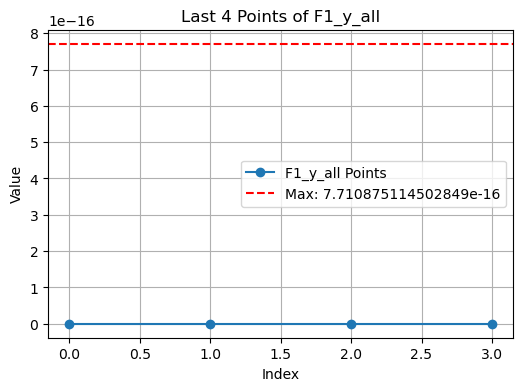

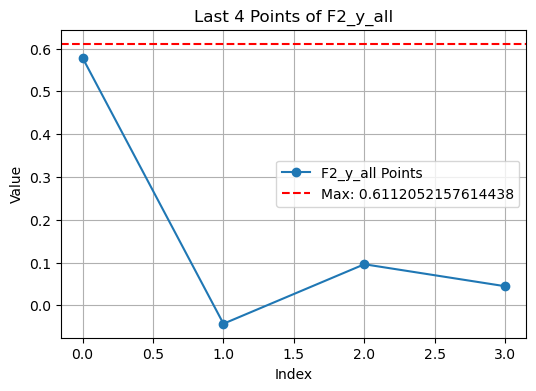

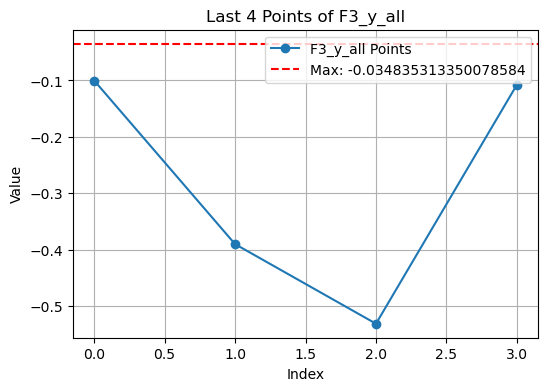

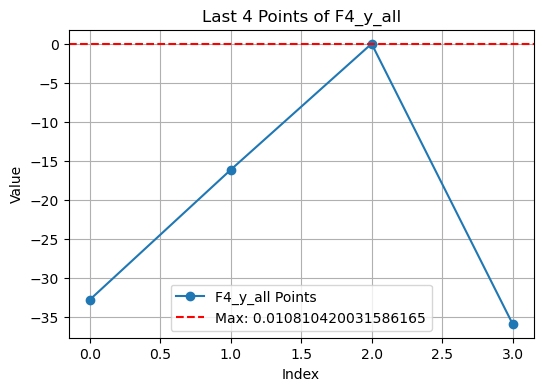

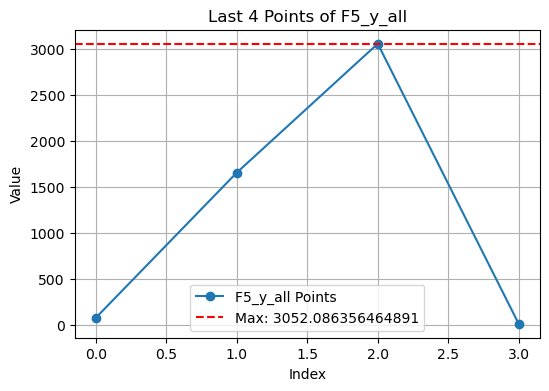

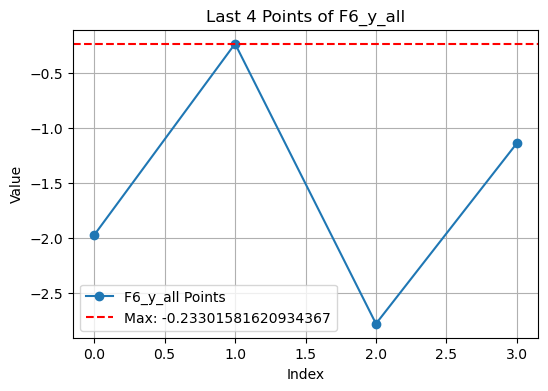

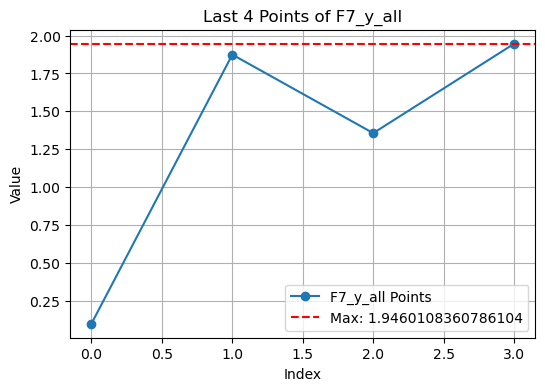

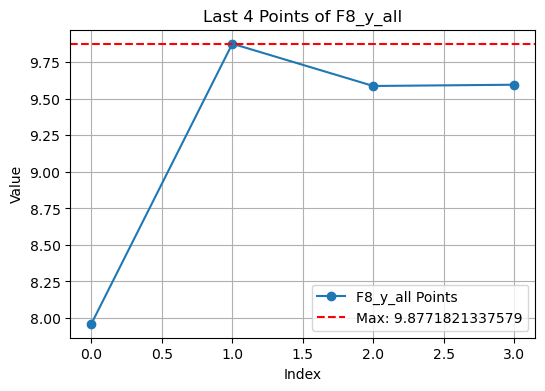

In [33]:
#plot last 4 guesses and current max
for key, values in y_all_dict.items():
    last_4_points = values[-4:]  # Get the last 4 points
    current_max = max(values)  
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(last_4_points)), last_4_points, marker='o', label=f"{key} Points")
    plt.axhline(y=current_max, color='red', linestyle='--', label=f"Max: {current_max}")
    plt.title(f"Last 4 Points of {key}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

**Plot all functions**

In [35]:
# create plots of all dimensions vs target
def plot_features_vs_target(x_data, y_data, title_prefix="Feature vs Target"):
    num_features = x_data.shape[1]  # Number of features (columns)
    num_cols = 3  # Number of columns in the grid
    num_rows = -(-num_features // num_cols)  # Calculate rows needed (ceil division)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows))  # Dynamic figure size based on rows and columns
    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)  # Create subplots in a grid
        plt.scatter(x_data[:, i], y_data, alpha=0.7)  # Scatter plot of feature vs target
        plt.title(f"{title_prefix}: x{i+1} vs y")
        plt.xlabel(f"x{i+1}")
        plt.ylabel("y") 
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Generating plots for F1


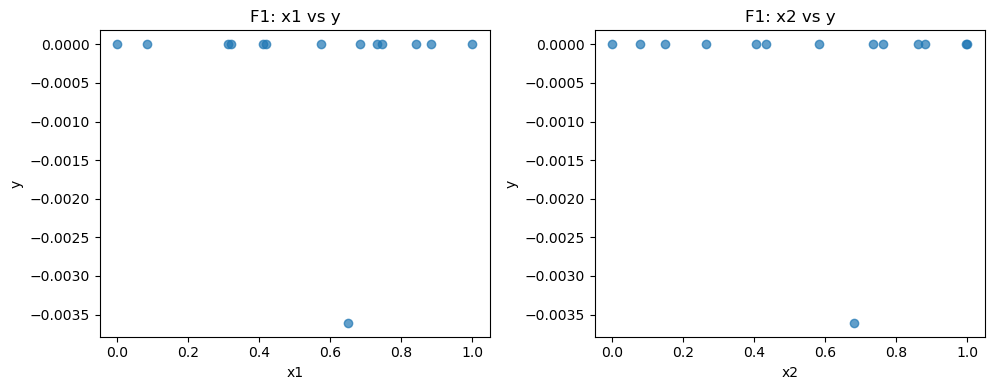

Generating plots for F2


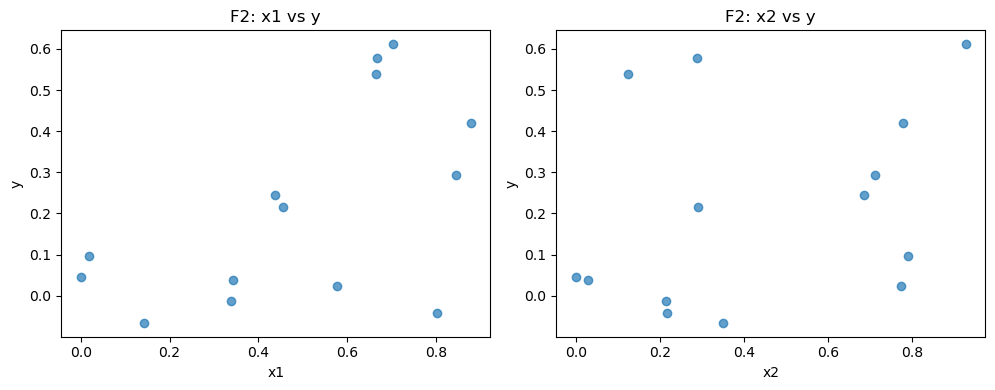

Generating plots for F3


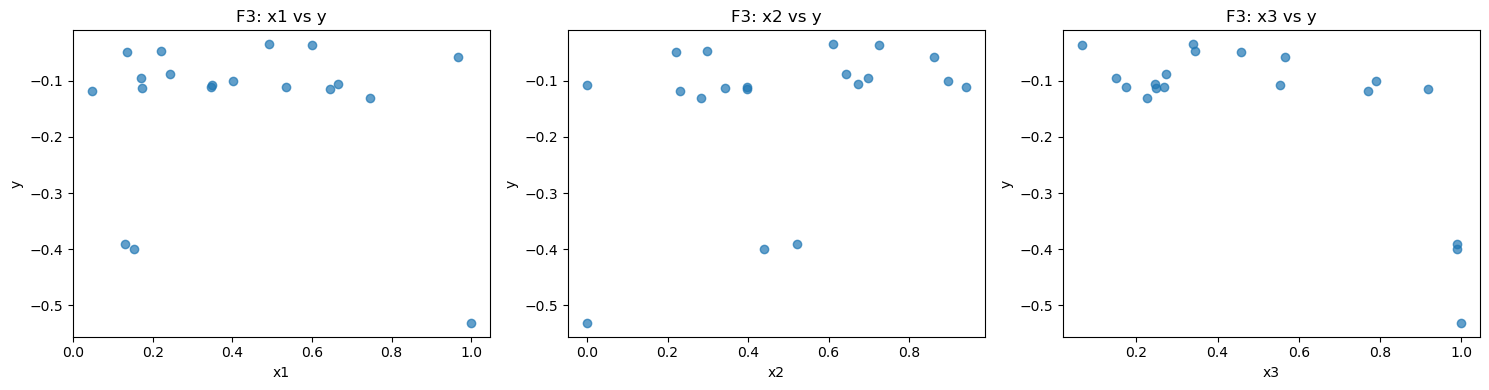

Generating plots for F4


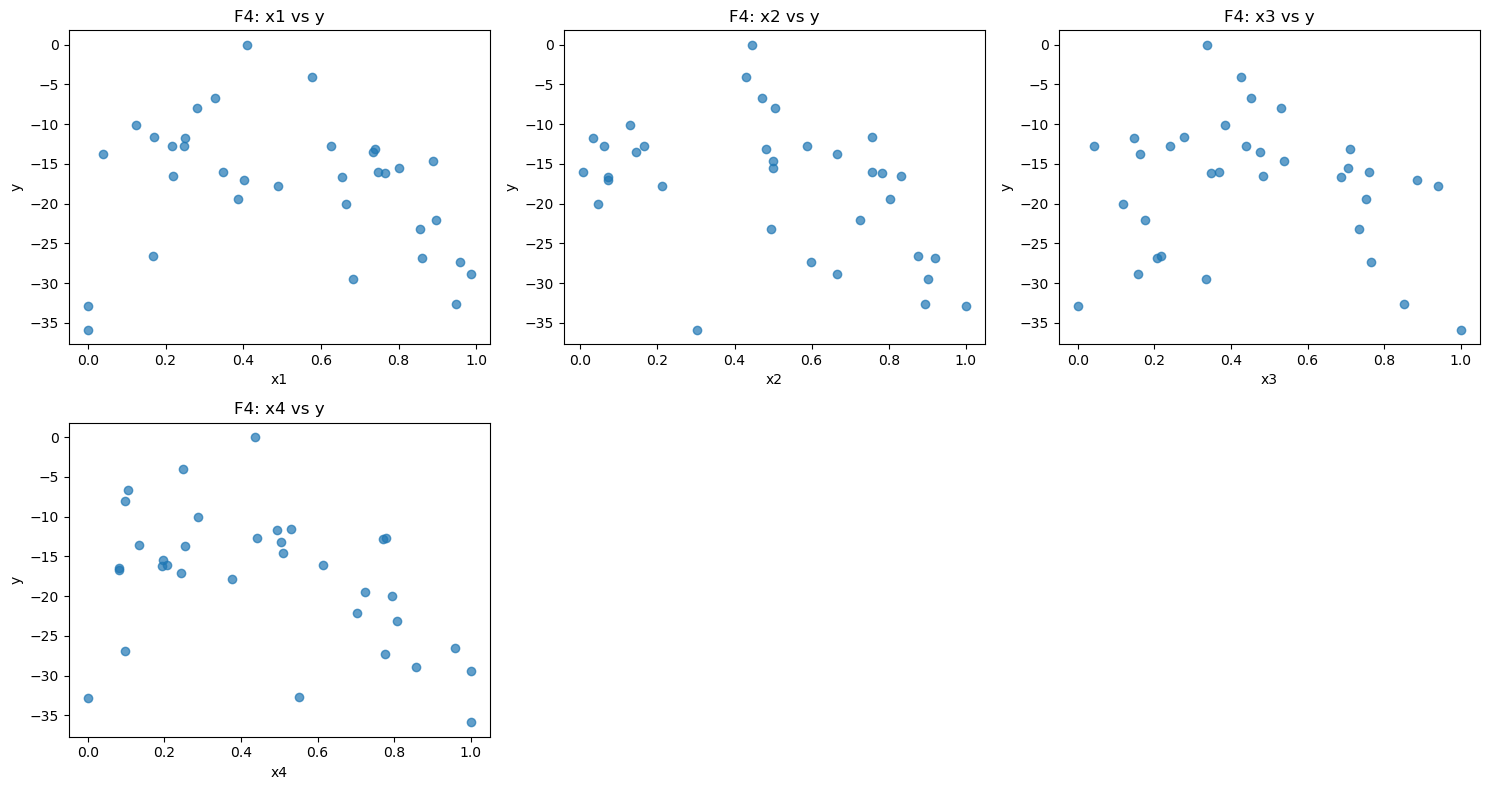

Generating plots for F5


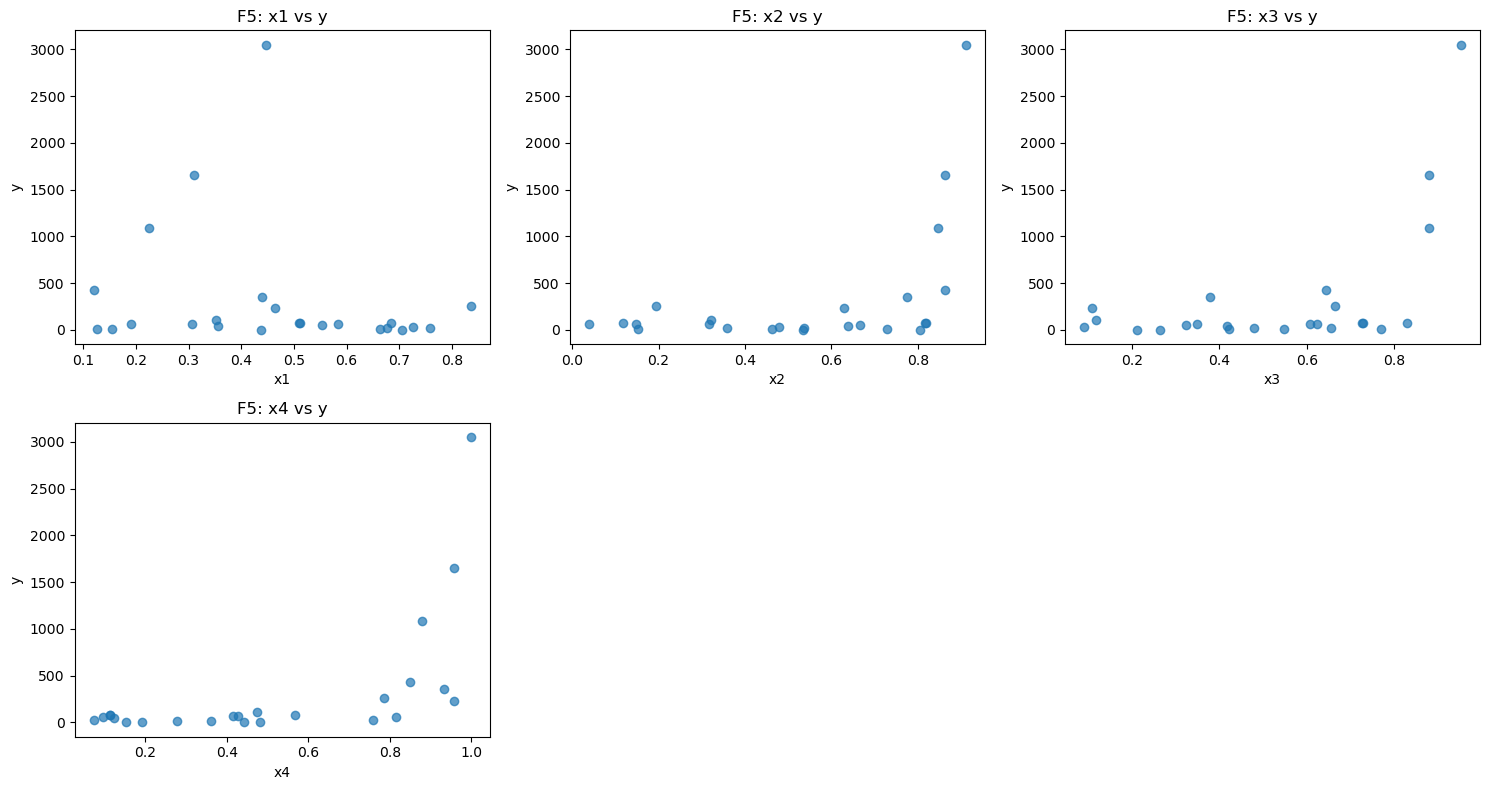

Generating plots for F6


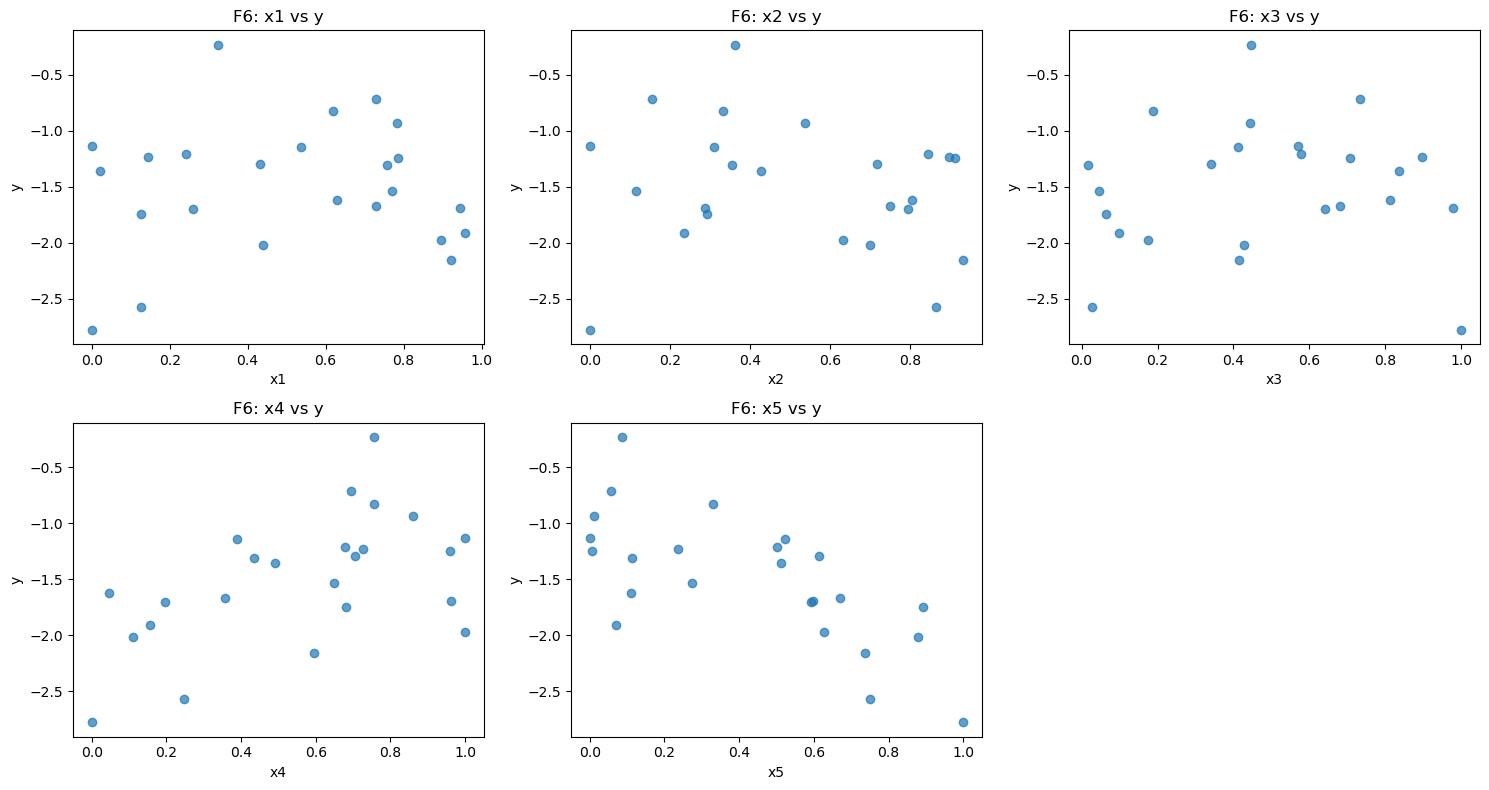

Generating plots for F7


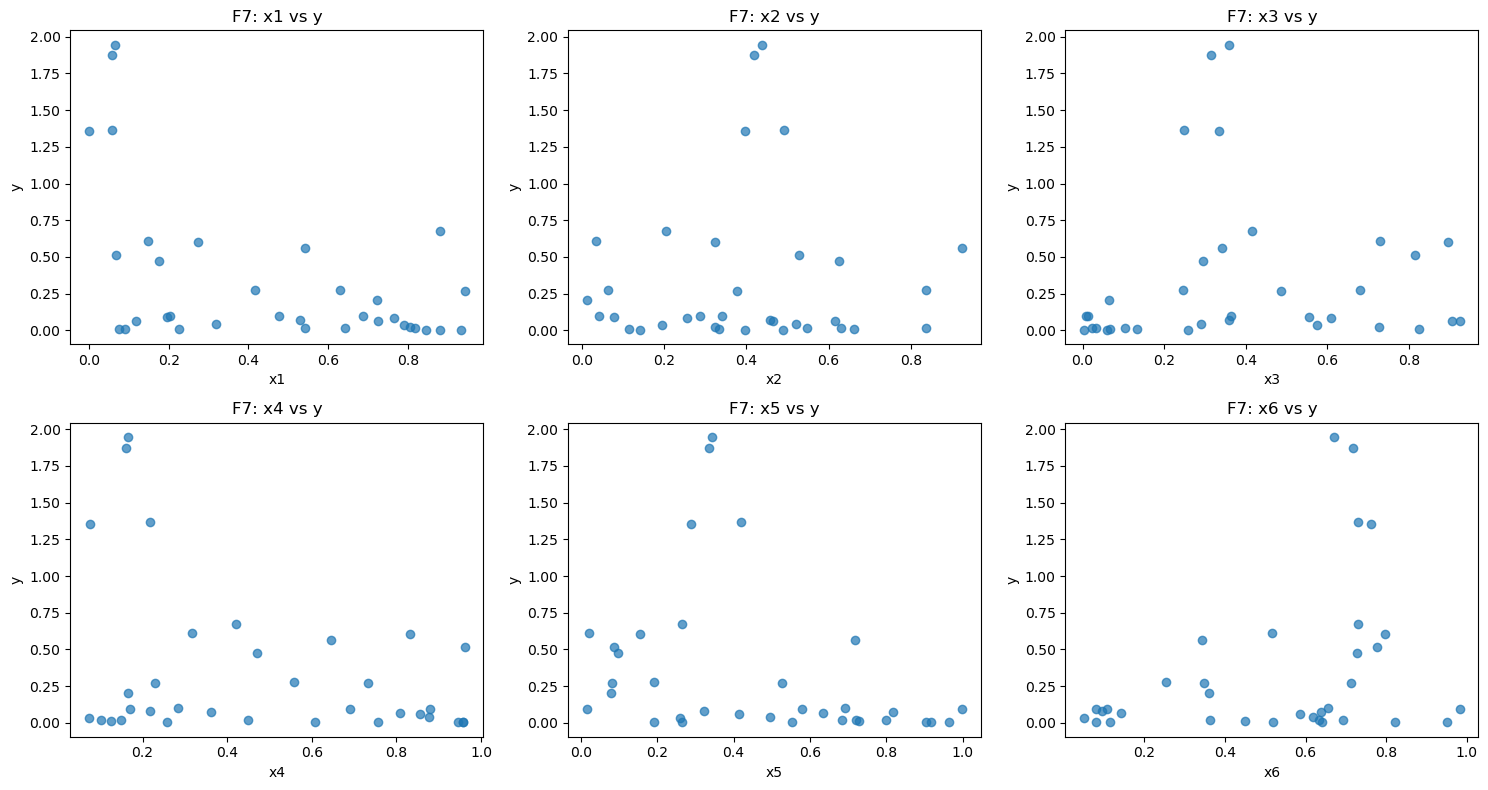

Generating plots for F8


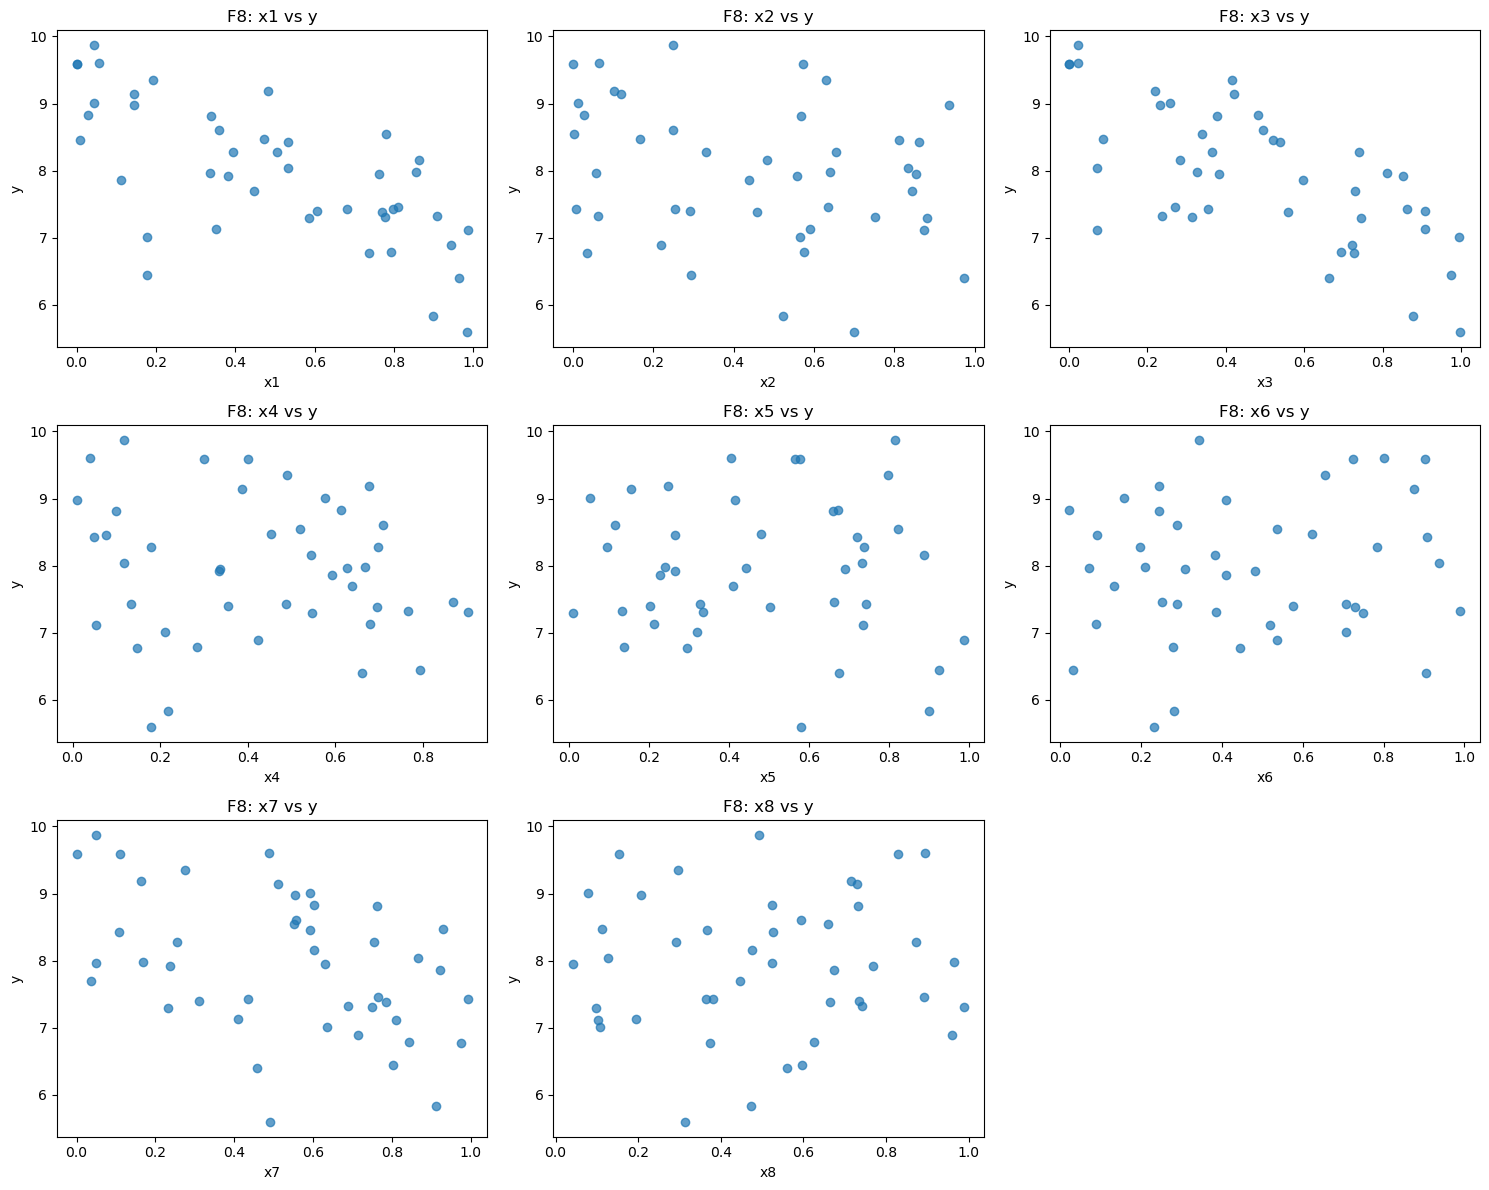

In [37]:
for key in x_all_dict.keys():
    x_data = x_all_dict[key]
    y_data = y_all_dict[key.replace("x_all", "y_all")]  
    title_prefix = key.replace("_x_all", "")  
    print(f"Generating plots for {title_prefix}")
    plot_features_vs_target(x_data, y_data, title_prefix=title_prefix)

**Standardise target variables for some functions**

To do: look more at impact of standardisation

In [39]:
functions_to_scale = ["F4", "F5", "F8"]
y_all_scaled_dict = {}

for key in y_all_dict.keys():
    y_data = y_all_dict[key]
    function_name = key.split("_")[0]  # Extract the function identifier (e.g., "F4")
    if function_name in functions_to_scale:
        y_scaler = StandardScaler()
        y_scaled = y_scaler.fit_transform(y_data.reshape(-1, 1)).ravel()
        y_all_scaled_dict[key] = y_scaled  # Store the scaled data
    else:
        y_all_scaled_dict[key] = y_data

In [59]:
#print(y_all_scaled_dict)

Generating plots for F1


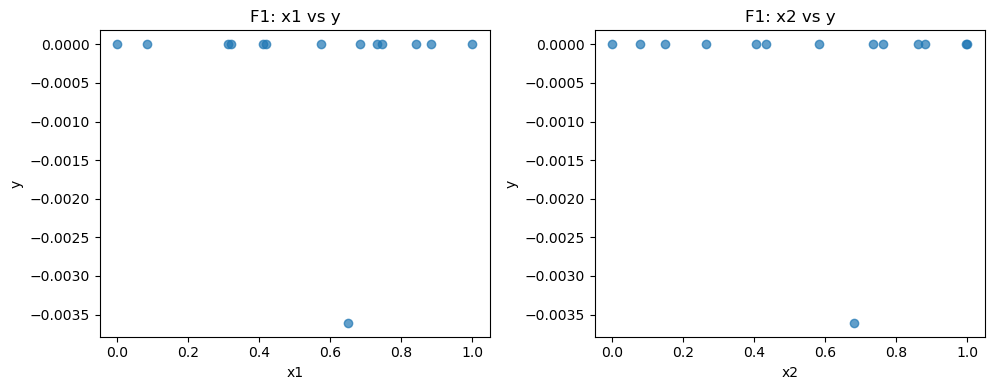

Generating plots for F2


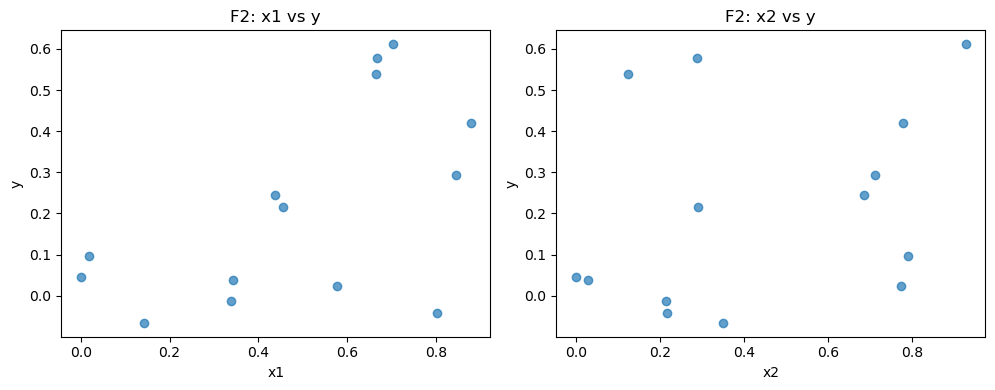

Generating plots for F3


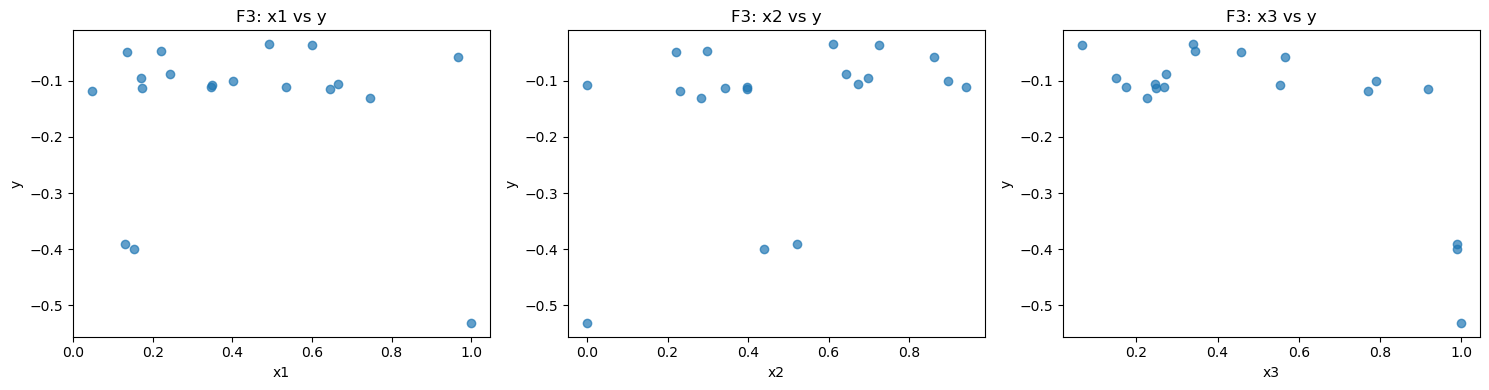

Generating plots for F4


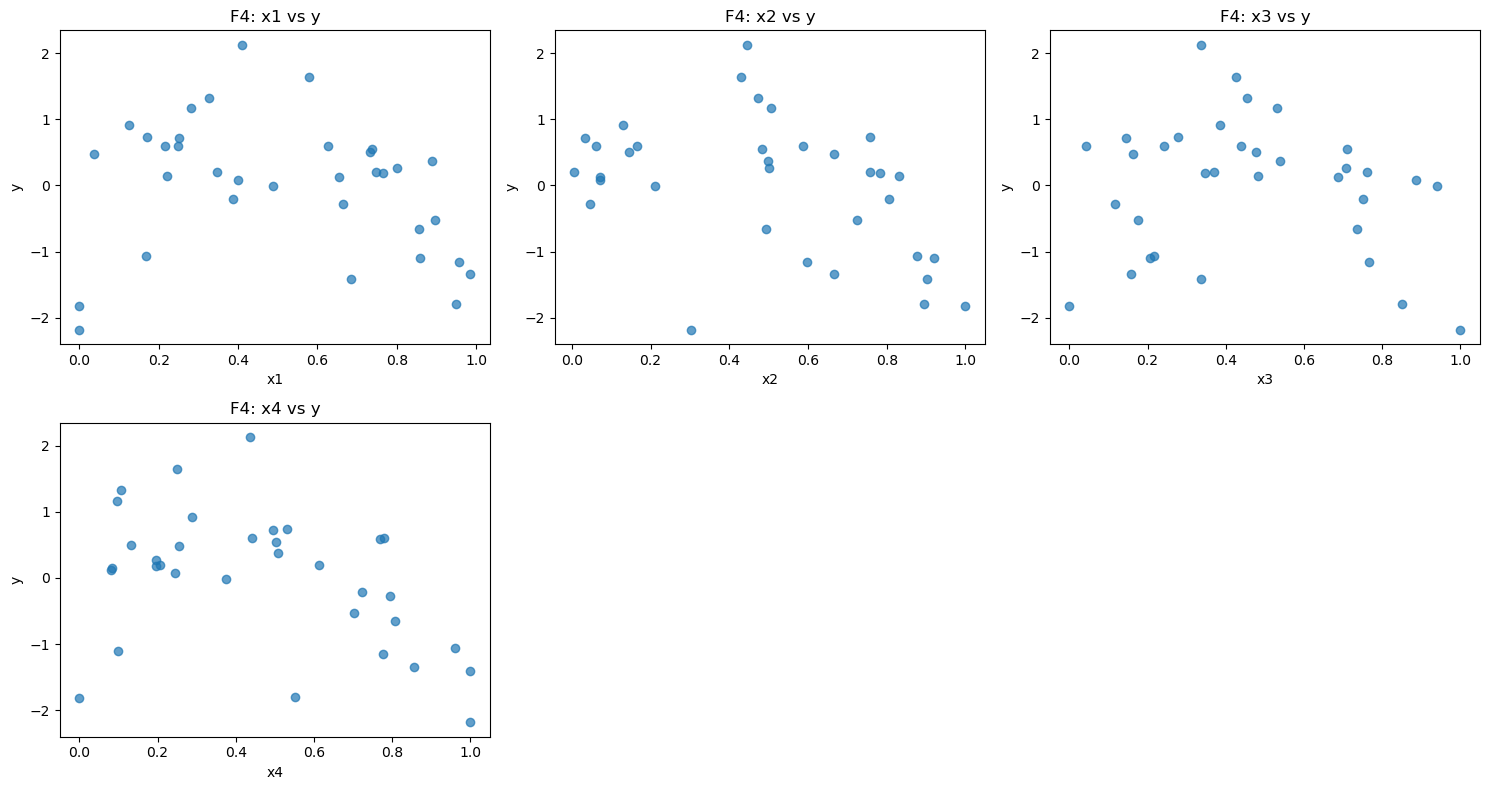

Generating plots for F5


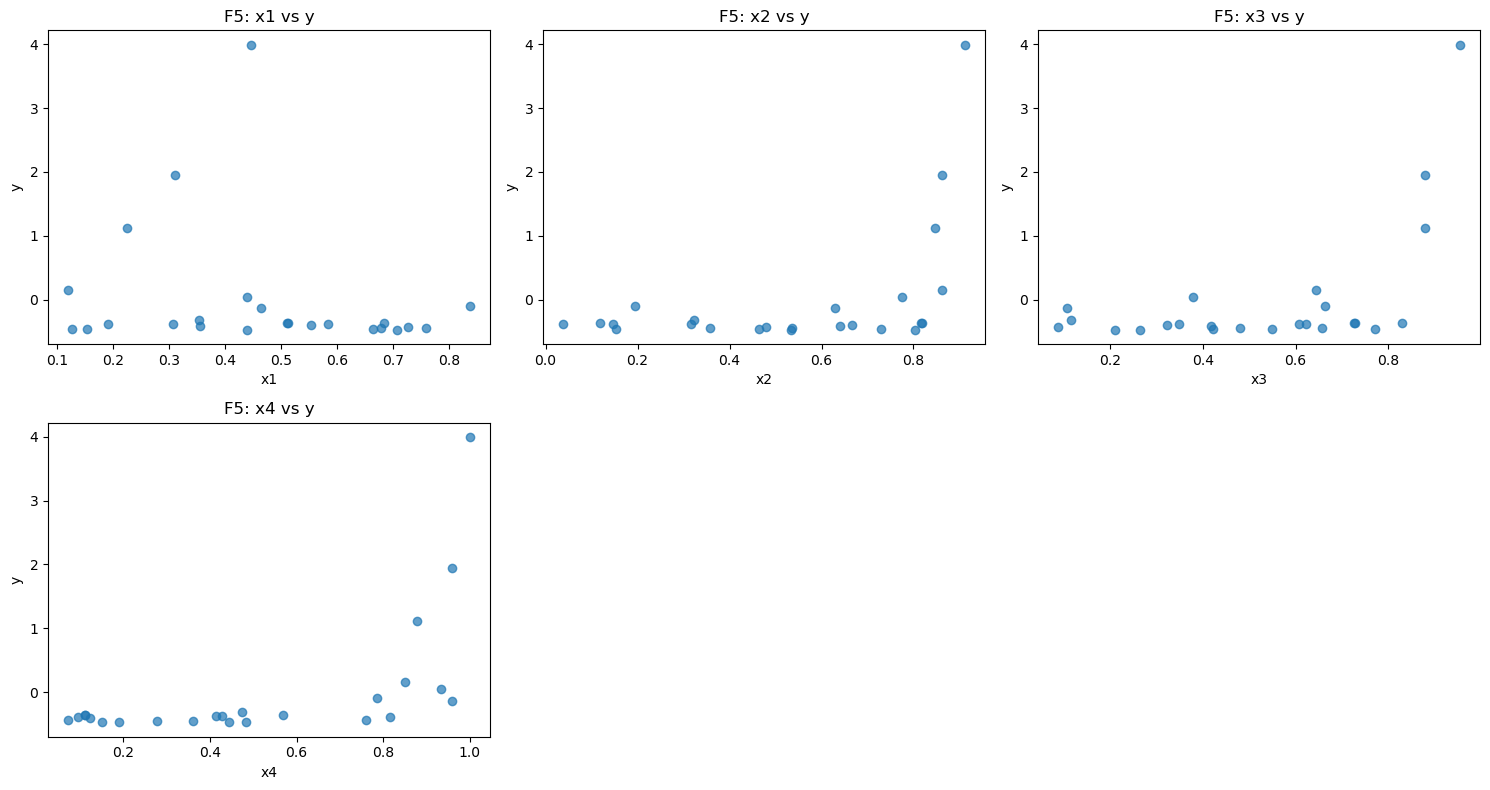

Generating plots for F6


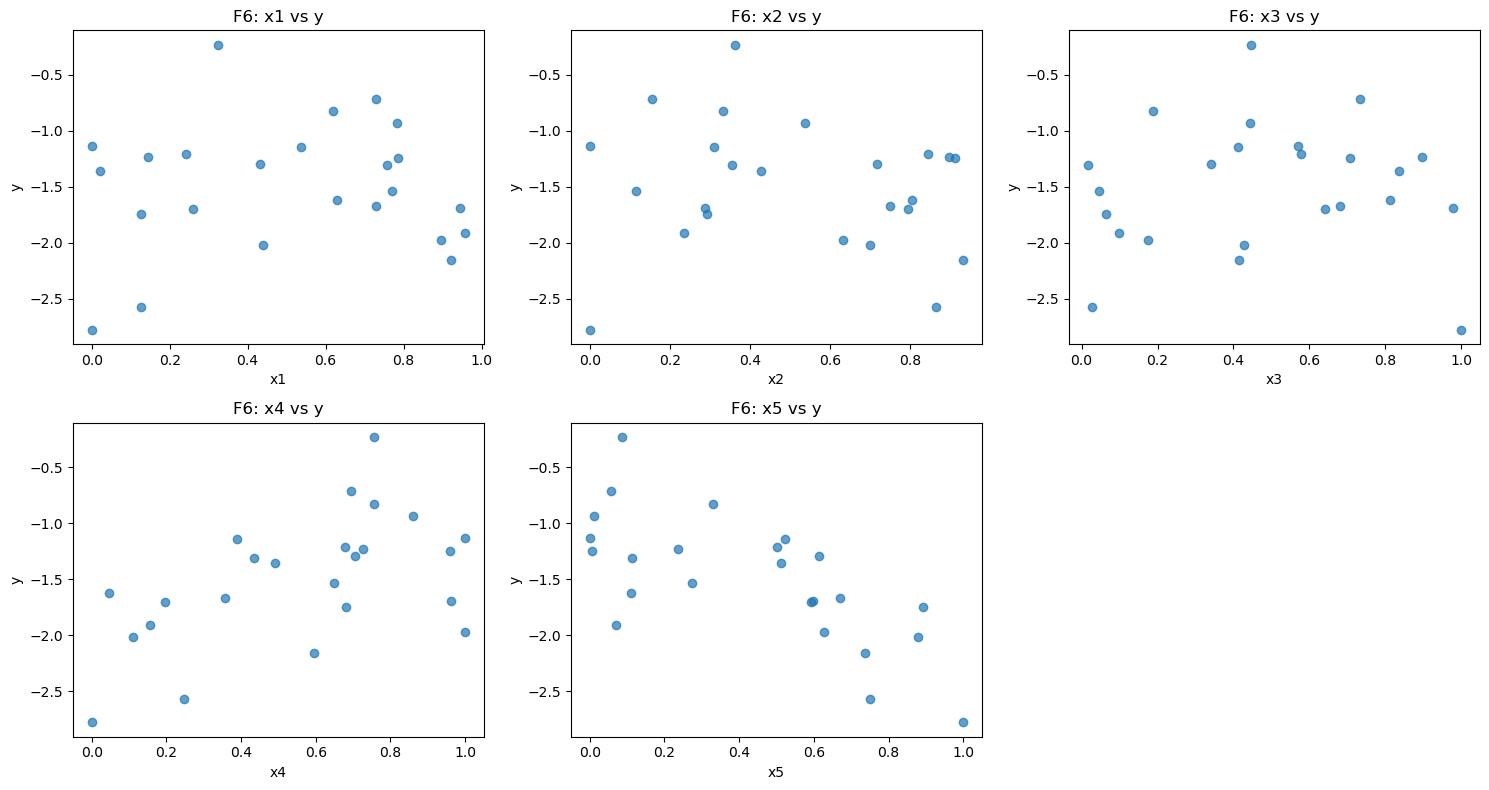

Generating plots for F7


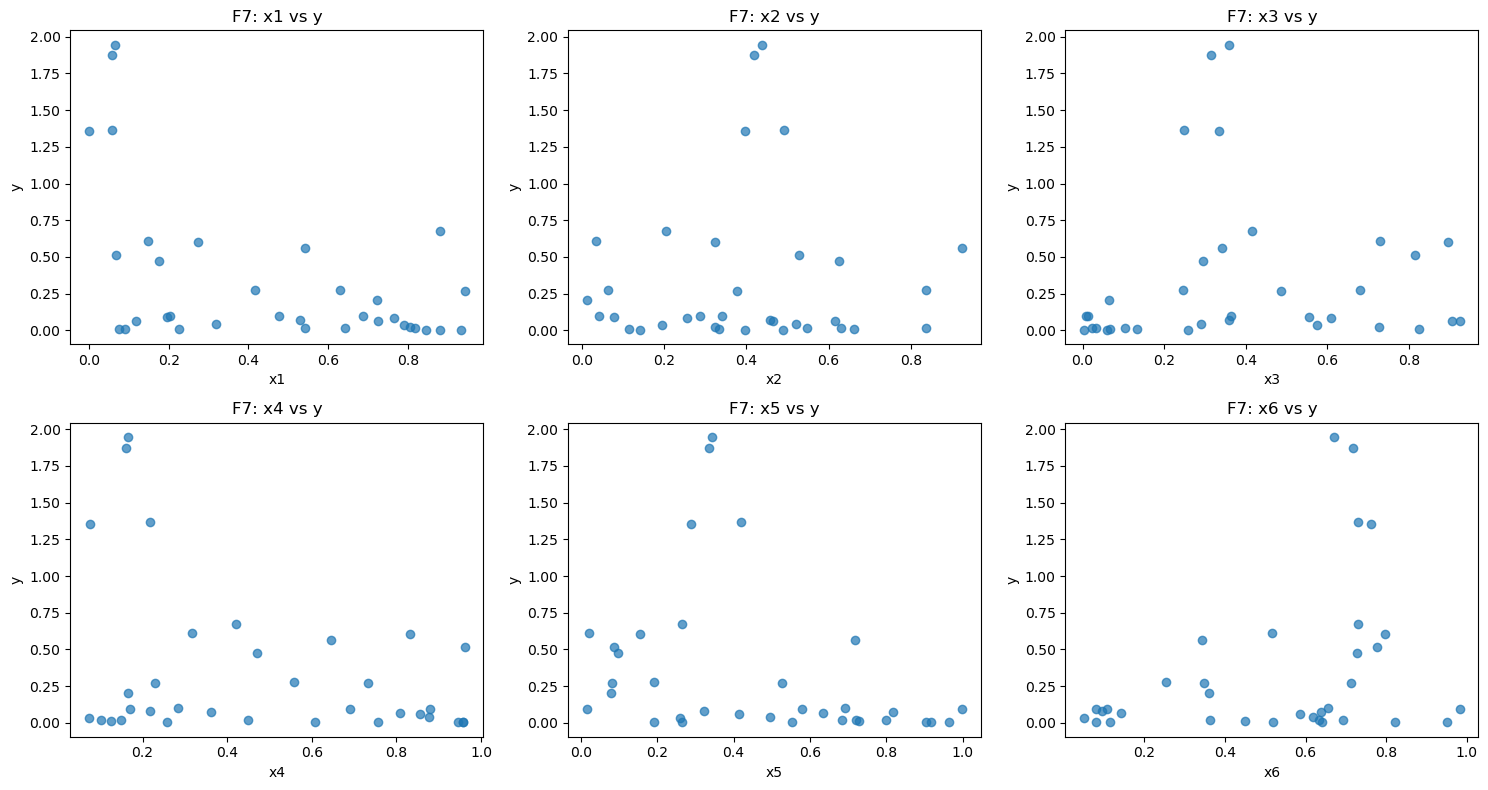

Generating plots for F8


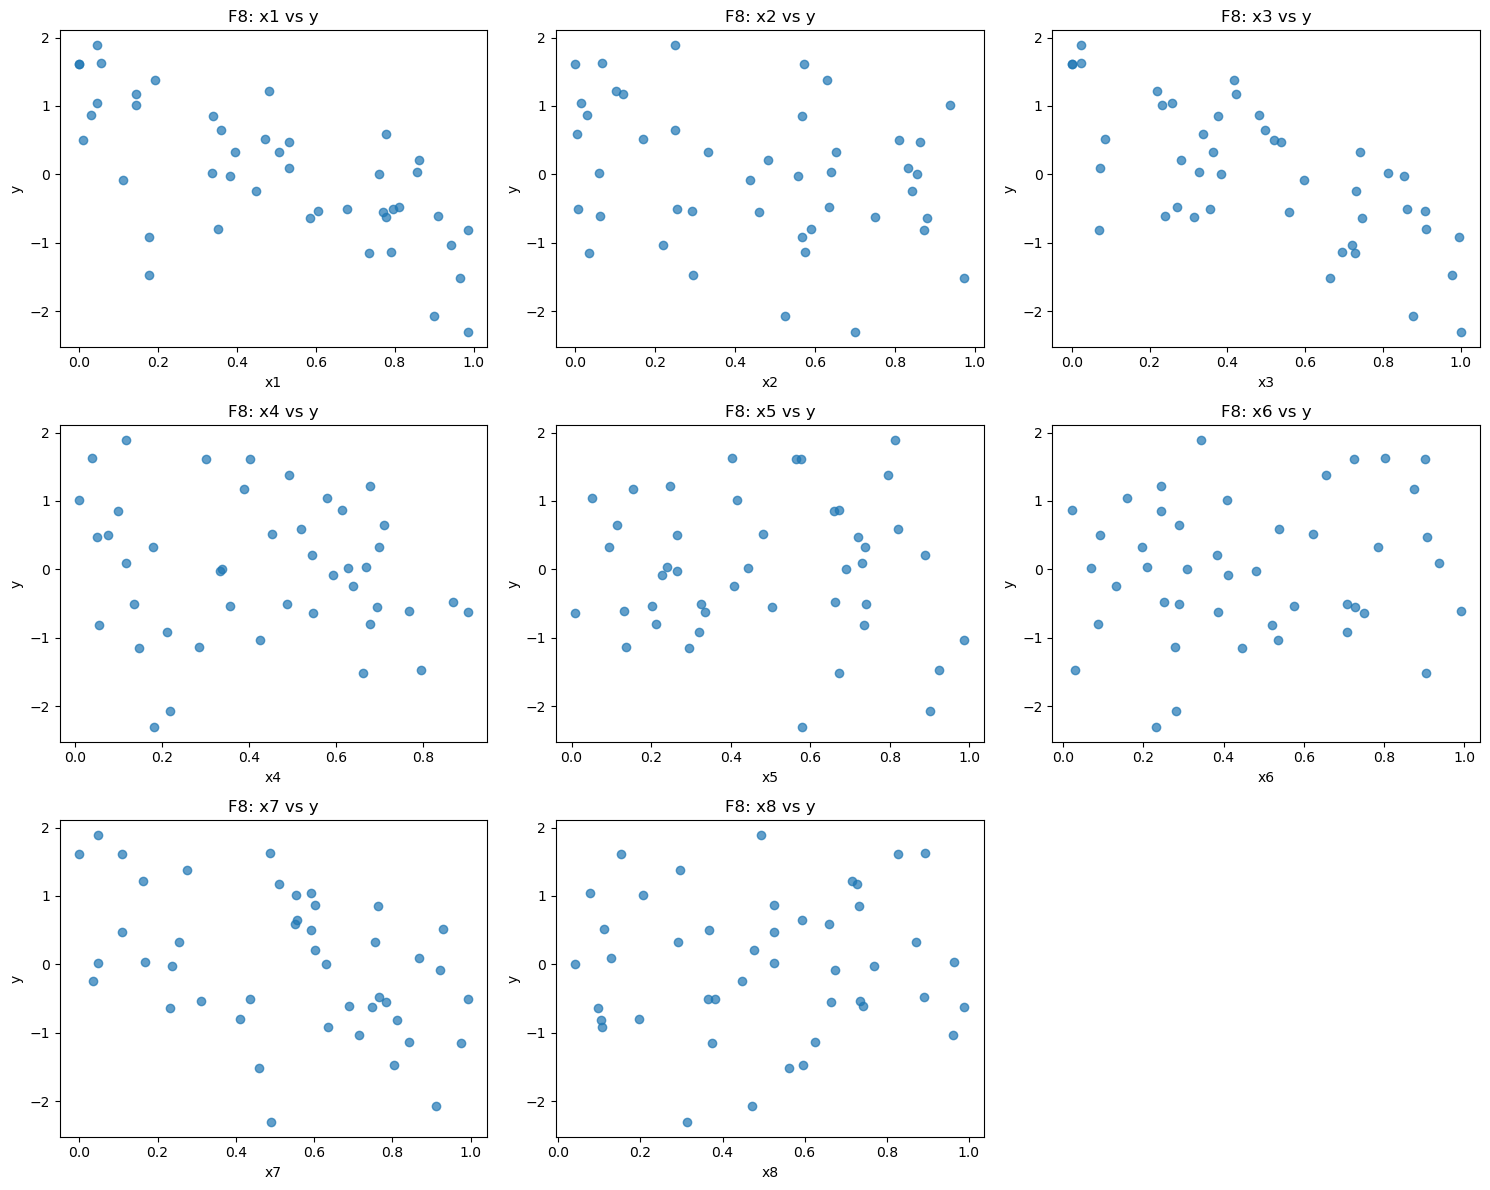

In [41]:
for key in x_all_dict.keys():
    x_data = x_all_dict[key]
    y_data = y_all_scaled_dict[key.replace("x_all", "y_all")]  
    title_prefix = key.replace("_x_all", "")  
    print(f"Generating plots for {title_prefix}")
    plot_features_vs_target(x_data, y_data, title_prefix=title_prefix)

**PCA analysis and PLS? TO DO**

Function 5 looks like first component is highly correlated with y - to check and work through

Try other kernals?

Performing PCA for F1_x_all...


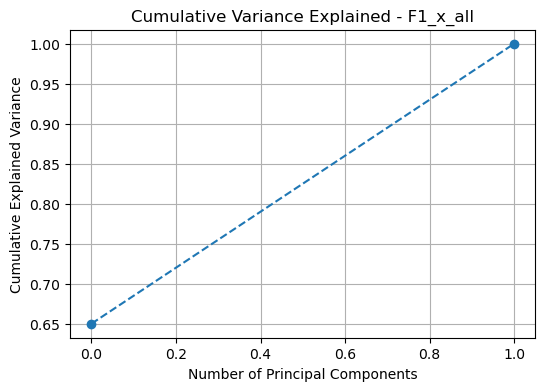

Performing PCA for F2_x_all...


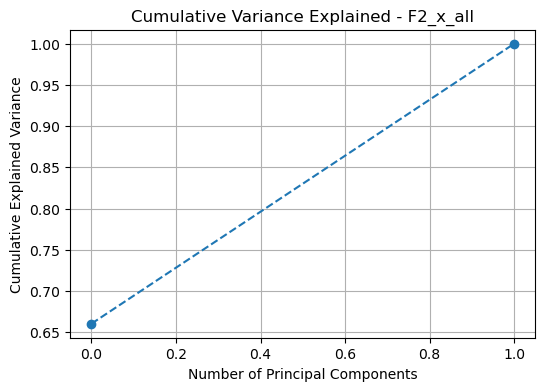

Performing PCA for F3_x_all...


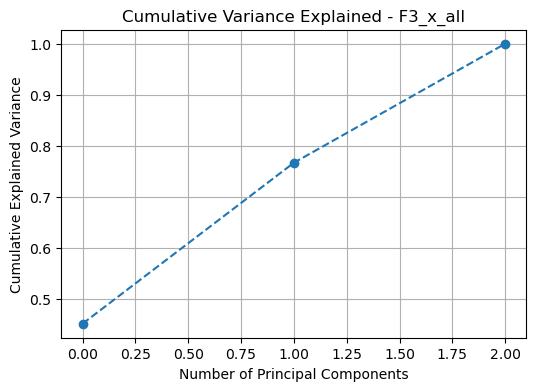

Performing PCA for F4_x_all...


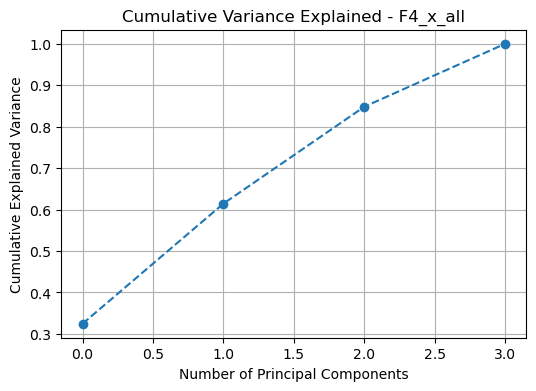

Performing PCA for F5_x_all...


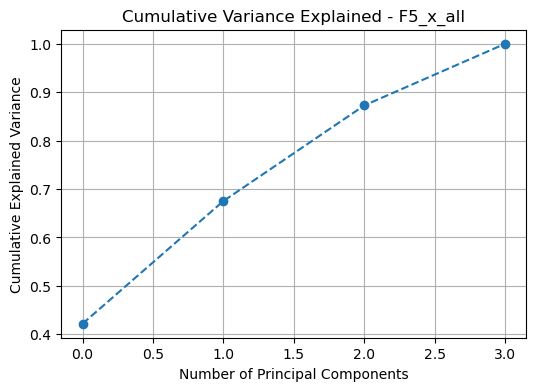

Performing PCA for F6_x_all...


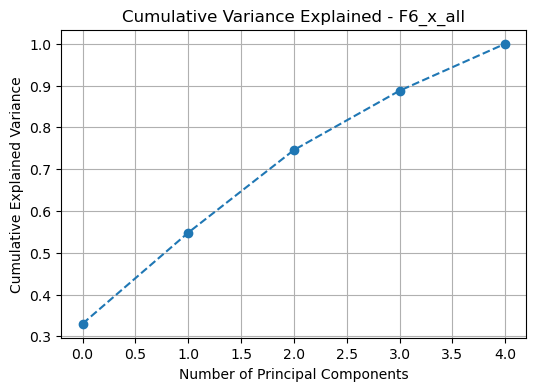

Performing PCA for F7_x_all...


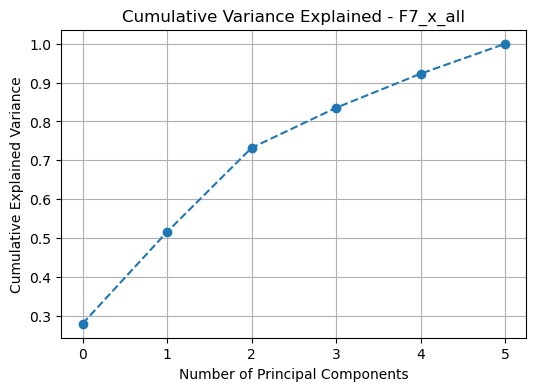

Performing PCA for F8_x_all...


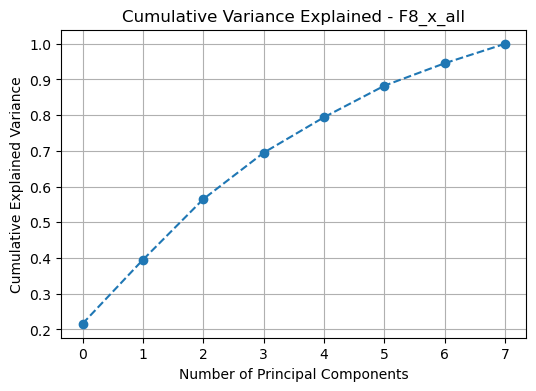

          Num Components  Explained Variance (1st Component)  \
F1_x_all               2                            0.650824   
F2_x_all               2                            0.660247   
F3_x_all               3                            0.451396   
F4_x_all               4                            0.324555   
F5_x_all               4                            0.421759   
F6_x_all               5                            0.330119   
F7_x_all               6                            0.279718   
F8_x_all               8                            0.215941   

          Cumulative Variance (First 2 Components)  Correlation PC1 & y  
F1_x_all                                  1.000000            -0.037680  
F2_x_all                                  1.000000             0.503726  
F3_x_all                                  0.766808            -0.690634  
F4_x_all                                  0.614302            -0.498684  
F5_x_all                                  0.675189   

In [101]:
pca_results = {}
for func_name, X_sample in x_all_dict.items():
    print(f"Performing PCA for {func_name}...")
    y_sample = y_all_dict[func_name.replace("x_all", "y_all")]
    pca = PCA()
    X_pca = pca.fit_transform(X_sample)
    pca_results[func_name] = {
        "explained_variance_ratio": pca.explained_variance_ratio_,
        "cumulative_variance": np.cumsum(pca.explained_variance_ratio_),
    }
    pc_y_correlation = [pearsonr(X_pca[:, i], y_sample)[0] for i in range(X_pca.shape[1])]
    pca_results[func_name]["pc_y_correlation"] = pc_y_correlation
    plt.figure(figsize=(6, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"Cumulative Variance Explained - {func_name}")
    plt.grid(True)
    plt.show()
pca_summary = {
    func_name: {
        "Num Components": len(pca_data["explained_variance_ratio"]),
        "Explained Variance (1st Component)": pca_data["explained_variance_ratio"][0],
        "Cumulative Variance (First 2 Components)": pca_data["cumulative_variance"][1] if len(pca_data["cumulative_variance"]) > 1 else pca_data["cumulative_variance"][0],
        "Correlation PC1 & y": pca_data["pc_y_correlation"][0]  # Correlation between PC1 and y
    }
    for func_name, pca_data in pca_results.items()
}
pca_summary_df = pd.DataFrame.from_dict(pca_summary, orient='index')
print(pca_summary_df)

**PLS - normalise?**

Performing PLS for F1_x_all...


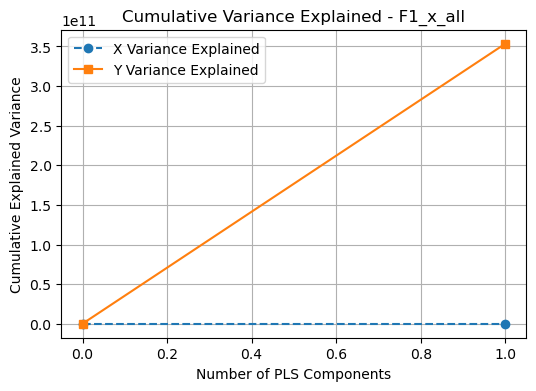

Performing PLS for F2_x_all...


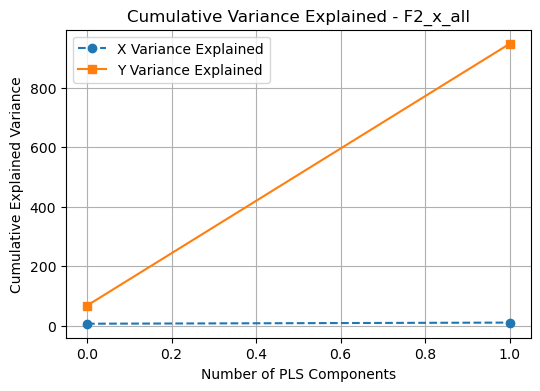

Performing PLS for F3_x_all...


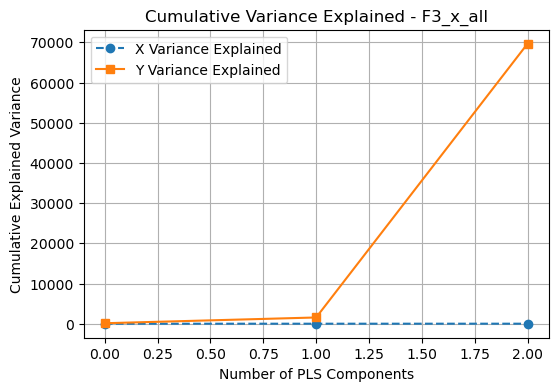

Performing PLS for F4_x_all...


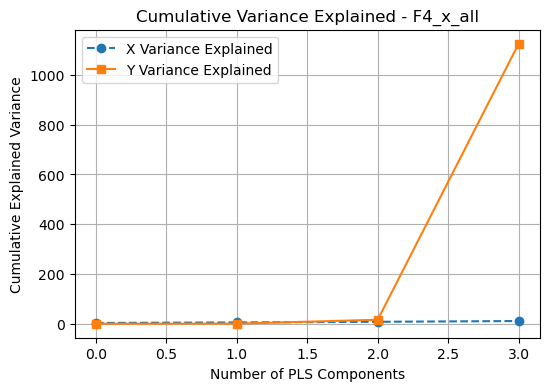

Performing PLS for F5_x_all...


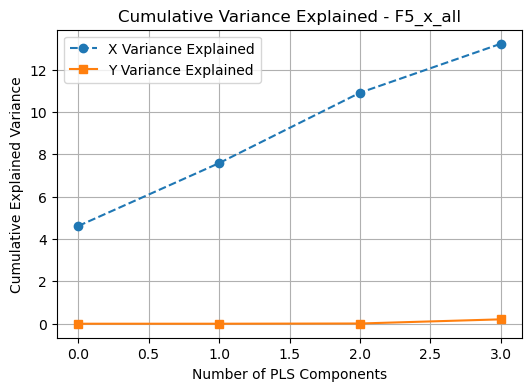

Performing PLS for F6_x_all...


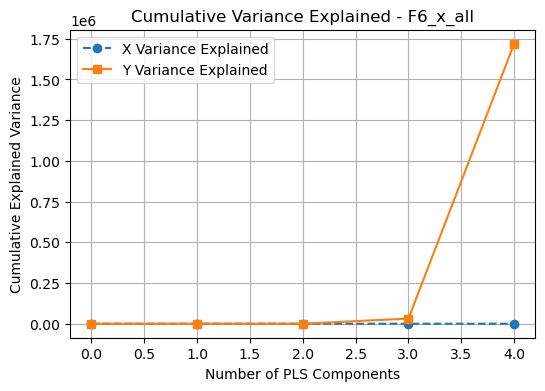

Performing PLS for F7_x_all...


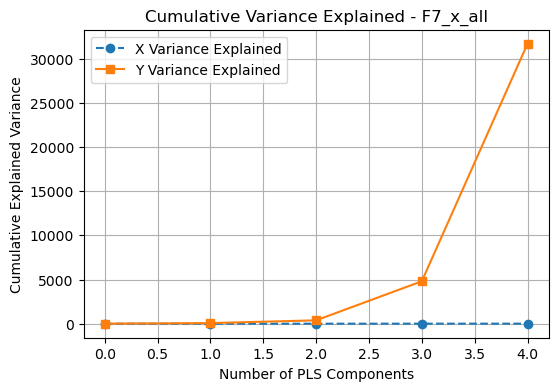

Performing PLS for F8_x_all...


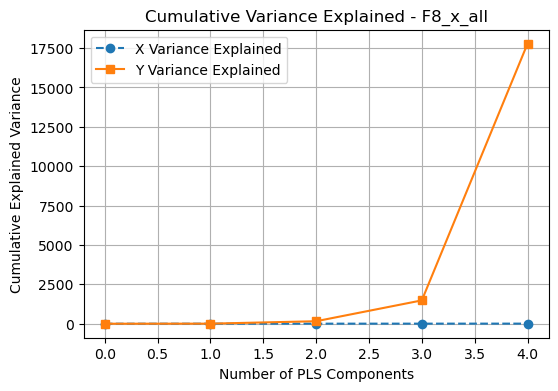

          Num Components  Explained Variance in X (1st Component)  \
F1_x_all               2                                 3.525852   
F2_x_all               2                                 6.686854   
F3_x_all               3                                 4.614470   
F4_x_all               4                                 3.147767   
F5_x_all               4                                 4.612778   
F6_x_all               5                                 2.868501   
F7_x_all               5                                 2.600475   
F8_x_all               5                                 2.163580   

          Explained Variance in Y (1st Component)  \
F1_x_all                             2.745020e+07   
F2_x_all                             6.775122e+01   
F3_x_all                             1.268531e+02   
F4_x_all                             4.442342e-02   
F5_x_all                             4.592907e-06   
F6_x_all                             7.768930e+00   
F7_x_al

In [108]:
pls_results = {}
for func_name, X_sample in x_all_dict.items():
    print(f"Performing PLS for {func_name}...")
    y_sample = y_all_dict[func_name.replace("x_all", "y_all")]
    n_components = min(X_sample.shape[1], 5)  # Limit to 5 components for interpretability
    pls = PLSRegression(n_components=n_components)
    X_pls = pls.fit_transform(X_sample, y_sample)[0]  # Get transformed X (scores)
    pls_results[func_name] = {
        "explained_variance_x": pls.x_scores_.var(axis=0) / X_sample.var(axis=0).sum(),
        "explained_variance_y": pls.y_scores_.var(axis=0) / y_sample.var(),
        "cumulative_variance_x": np.cumsum(pls.x_scores_.var(axis=0) / X_sample.var(axis=0).sum()),
        "cumulative_variance_y": np.cumsum(pls.y_scores_.var(axis=0) / y_sample.var())
    }
    plt.figure(figsize=(6, 4))
    plt.plot(pls_results[func_name]["cumulative_variance_x"], marker='o', linestyle='--', label="X Variance Explained")
    plt.plot(pls_results[func_name]["cumulative_variance_y"], marker='s', linestyle='-', label="Y Variance Explained")
    plt.xlabel("Number of PLS Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"Cumulative Variance Explained - {func_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

pls_summary = {
    func_name: {
        "Num Components": len(pls_data["explained_variance_x"]),
        "Explained Variance in X (1st Component)": pls_data["explained_variance_x"][0],
        "Explained Variance in Y (1st Component)": pls_data["explained_variance_y"][0],
        "Cumulative Variance in X (First 2 Components)": pls_data["cumulative_variance_x"][1] if len(pls_data["cumulative_variance_x"]) > 1 else pls_data["cumulative_variance_x"][0],
        "Cumulative Variance in Y (First 2 Components)": pls_data["cumulative_variance_y"][1] if len(pls_data["cumulative_variance_y"]) > 1 else pls_data["cumulative_variance_y"][0]
    }
    for func_name, pls_data in pls_results.items()
}

pls_summary_df = pd.DataFrame.from_dict(pls_summary, orient='index')
print(pls_summary_df)

**PCA with scaling**

Performing PCA for F1_x_all...


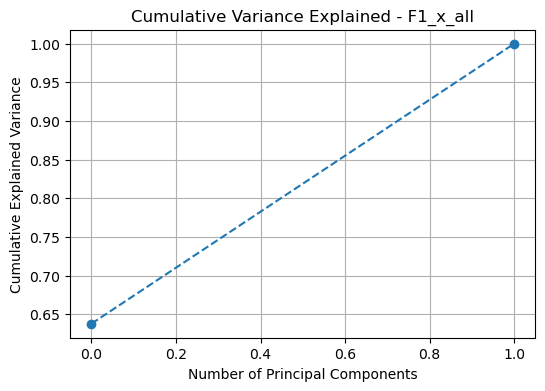

Performing PCA for F2_x_all...


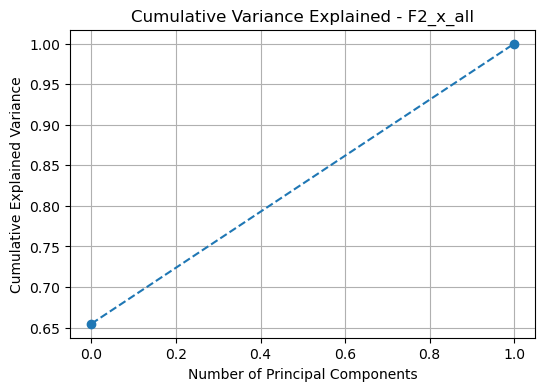

Performing PCA for F3_x_all...


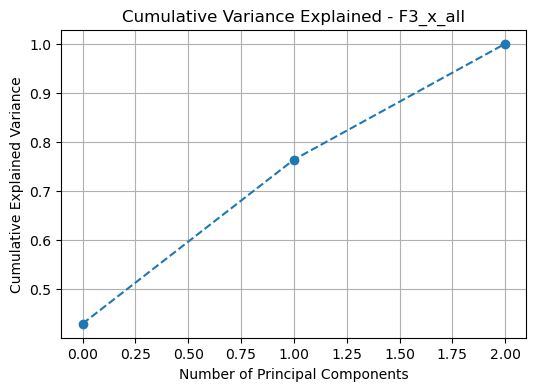

Performing PCA for F4_x_all...


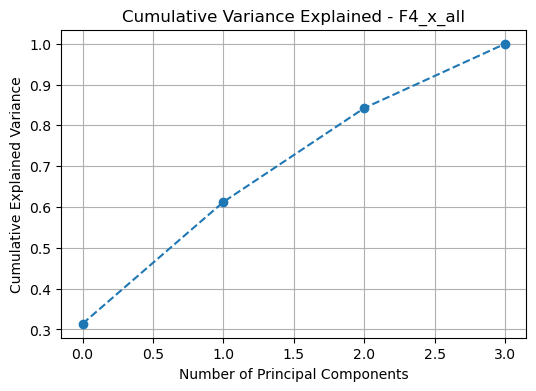

Performing PCA for F5_x_all...


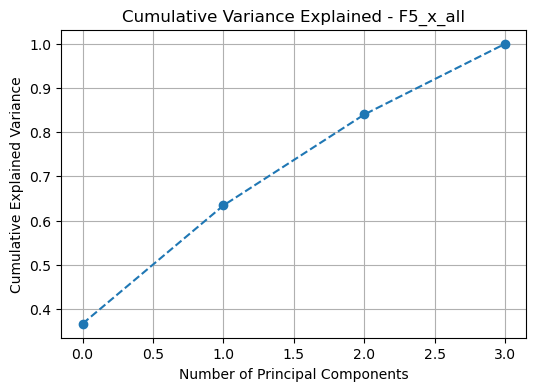

Performing PCA for F6_x_all...


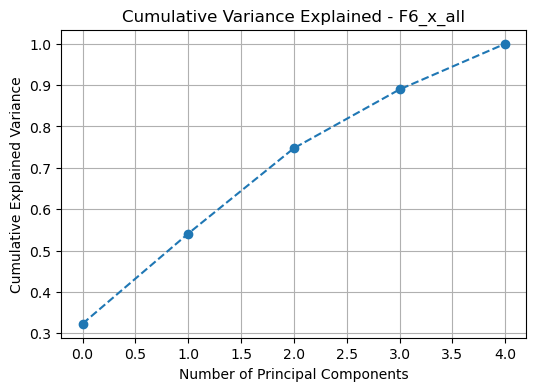

Performing PCA for F7_x_all...


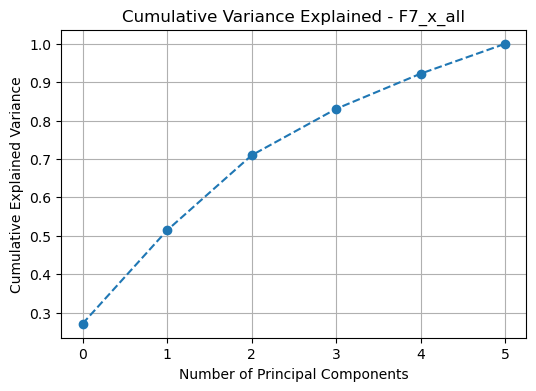

Performing PCA for F8_x_all...


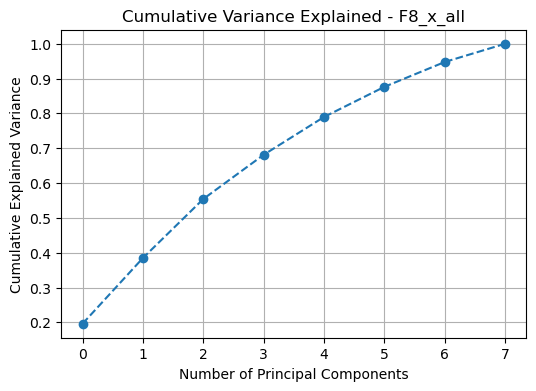

          Num Components  Explained Variance (1st Component)  \
F1_x_all               2                            0.637691   
F2_x_all               2                            0.654744   
F3_x_all               3                            0.430082   
F4_x_all               4                            0.313892   
F5_x_all               4                            0.366540   
F6_x_all               5                            0.323105   
F7_x_all               6                            0.270876   
F8_x_all               8                            0.196088   

          Cumulative Variance (First 2 Components)  
F1_x_all                                  1.000000  
F2_x_all                                  1.000000  
F3_x_all                                  0.764076  
F4_x_all                                  0.612359  
F5_x_all                                  0.634145  
F6_x_all                                  0.540993  
F7_x_all                                  0.514072  

In [93]:
pca_results = {}

for func_name, X_sample in x_all_dict.items():
    print(f"Performing PCA for {func_name}...")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sample)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    pca_results[func_name] = {
        "explained_variance_ratio": pca.explained_variance_ratio_,
        "cumulative_variance": np.cumsum(pca.explained_variance_ratio_)
    }
    plt.figure(figsize=(6, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"Cumulative Variance Explained - {func_name}")
    plt.grid(True)
    plt.show()
pca_summary = {
    func_name: {
        "Num Components": len(pca_data["explained_variance_ratio"]),
        "Explained Variance (1st Component)": pca_data["explained_variance_ratio"][0],
        "Cumulative Variance (First 2 Components)": pca_data["cumulative_variance"][1] if len(pca_data["cumulative_variance"]) > 1 else pca_data["cumulative_variance"][0]
    }
    for func_name, pca_data in pca_results.items()
}
pca_summary_df = pd.DataFrame.from_dict(pca_summary, orient='index')
print(pca_summary_df)

**Create generic acquisition functions**

In [43]:
def acquisition_function_UCB(X, y_sample, model, beta=2.5):
    X = np.atleast_2d(X)
    mu, sigma = model.predict(X, return_std=True)
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    with np.errstate(divide="warn"):
        UC_bound = mu + beta * sigma
    return UC_bound.ravel() #Returns the UCB values as a 1D array for the input candidate points X.

In [45]:
def acquisition_function_var(X, y_sample, model):
    X = np.atleast_2d(X)
    mu, sigma = model.predict(X, return_std=True)
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    with np.errstate(divide="warn"):
        UC_bound = sigma
    return UC_bound.ravel() 

In [47]:
def acquisition_function_EI(X, y_sample, model, xi=0.01):
    X = np.atleast_2d(X)
    mu, sigma = model.predict(X, return_std=True)
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    y_best = np.max(y_sample)
    with np.errstate(divide="warn"):
        Z = (y_best - mu-xi) / sigma
        ei = (y_best - mu-xi) * scipy.stats.norm.cdf(Z) + sigma * scipy.stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.ravel()

In [49]:
def propose_next_point(acquisition, y_sample, model, bounds):
    """Propose the next point to sample and return all evaluated points and their acquisition values."""
    evaluated_points = []  
    evaluated_values = []  
    def min_obj(X):
        """Wrap the acquisition function to record evaluations."""
        value = -acquisition(X, y_sample, model)  #maximisation
        evaluated_points.append(X)  
        evaluated_values.append(value)  
        return value
    x0 = np.random.uniform(bounds[:, 0], bounds[:, 1], size=len(bounds))  # Generate a 1D random initial guess
    res = minimize(min_obj, x0=x0, bounds=bounds, method="L-BFGS-B") 
    return res.x, np.array(evaluated_points), -np.array(evaluated_values), res.message

**Optimisation model**

TO DO: think more about the paramterisiation https://infallible-thompson-49de36.netlify.app/

Make bounds of parameter search more specific and hone in on granularity? May also enable more cross valiadtion folds - run time

Can we use Optuna to tune the parameters?

Assess how well the acquistion functions are working?

Next step: look at SVM + Gaussian ensemble

In [128]:
def optimize_gp_cv(acquisition_function, bounds, X_sample, y_sample, n_splits=5):
    """
    Optimizes a Gaussian Process model using cross-validation and retrains the best model on full data.
    
    Parameters:
        acquisition_function: Function to evaluate acquisition values.
        bounds (array-like): Bounds for the parameters.
        X_sample (ndarray): Sampled input data.
        y_sample (ndarray): Corresponding observed outputs.
        n_splits (int): Number of cross-validation splits.  
    
    Returns:
        dict: Best model parameters, LML, MSE, next evaluation point, and retrained GP model.
    """
    warnings.simplefilter("ignore", category=UserWarning)
    
    nu_values = np.linspace(0.5, 5, 10)  # for Matern kernel
    length_scale_values = np.logspace(-3, 2, 7)  
    alpha_values = np.logspace(-3, 3, 7)  
    rq_alpha_values = np.logspace(-2, 2, 5) 

    # Define kernels with only relevant parameters
    kernels_to_compare = {
        "Matern": {
            "kernel_fn": lambda nu, ls: Matern(nu=nu, length_scale=ls, length_scale_bounds=(1e-3, 1e2)),
            "parameters": {"nu": nu_values, "length_scale": length_scale_values}
        },
        "RBF": {
            "kernel_fn": lambda _, ls: RBF(length_scale=ls, length_scale_bounds=(1e-3, 1e2)),
            "parameters": {"length_scale": length_scale_values}
        },
        "RationalQuadratic": {
            "kernel_fn": lambda _, ls, rq_alpha: RationalQuadratic(length_scale=ls, alpha=rq_alpha, length_scale_bounds=(1e-3, 1e2)),
            "parameters": {"length_scale": length_scale_values, "rq_alpha": rq_alpha_values}
        }
    }

    best_lml = -np.inf
    best_params = None
    best_kernel = None
    best_gp = None
    best_alpha = None
    best_fold_mse = None  # Store MSE as the average of the folds for the best model

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for kernel_name, kernel_info in kernels_to_compare.items():
        kernel_fn = kernel_info["kernel_fn"]
        parameters = kernel_info["parameters"]

        for length_scale in parameters.get("length_scale", [None]):
            for alpha in alpha_values:
                if kernel_name == "Matern":
                    for nu in parameters["nu"]:
                        lml_scores = []
                        fold_mse_scores = []
                        for train_idx, val_idx in kf.split(X_sample):
                            X_train, X_val = X_sample[train_idx], X_sample[val_idx]
                            y_train, y_val = y_sample[train_idx], y_sample[val_idx]
                            kernel = kernel_fn(nu, length_scale)
                            gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=5)
                            gp.fit(X_train, y_train)
                            lml_scores.append(gp.log_marginal_likelihood_value_)
                            y_val_pred = gp.predict(X_val)
                            fold_mse_scores.append(mean_squared_error(y_val, y_val_pred))
                        avg_lml = np.mean(lml_scores)
                        avg_fold_mse = np.mean(fold_mse_scores)  # Average MSE across folds
                        if avg_lml > best_lml:
                            best_lml = avg_lml
                            best_params = {"kernel": kernel_name, "nu": nu, "length_scale": length_scale, "alpha": alpha}
                            best_kernel = kernel
                            best_alpha = alpha
                            best_fold_mse = avg_fold_mse

                elif kernel_name == "RationalQuadratic":
                    for rq_alpha in parameters["rq_alpha"]:
                        lml_scores = []
                        fold_mse_scores = []
                        for train_idx, val_idx in kf.split(X_sample):
                            X_train, X_val = X_sample[train_idx], X_sample[val_idx]
                            y_train, y_val = y_sample[train_idx], y_sample[val_idx]
                            kernel = kernel_fn(None, length_scale, rq_alpha)
                            gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=5)
                            gp.fit(X_train, y_train)
                            lml_scores.append(gp.log_marginal_likelihood_value_)
                            y_val_pred = gp.predict(X_val)
                            fold_mse_scores.append(mean_squared_error(y_val, y_val_pred))
                        avg_lml = np.mean(lml_scores)
                        avg_fold_mse = np.mean(fold_mse_scores)
                        if avg_lml > best_lml:
                            best_lml = avg_lml
                            best_params = {"kernel": kernel_name, "length_scale": length_scale, "alpha": alpha, "rq_alpha": rq_alpha}
                            best_kernel = kernel
                            best_alpha = alpha
                            best_fold_mse = avg_fold_mse

                else:  # RBF kernel
                    lml_scores = []
                    fold_mse_scores = []
                    for train_idx, val_idx in kf.split(X_sample):
                        X_train, X_val = X_sample[train_idx], X_sample[val_idx]
                        y_train, y_val = y_sample[train_idx], y_sample[val_idx]
                        kernel = kernel_fn(None, length_scale)
                        gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=5)
                        gp.fit(X_train, y_train)
                        lml_scores.append(gp.log_marginal_likelihood_value_)
                        y_val_pred = gp.predict(X_val)
                        fold_mse_scores.append(mean_squared_error(y_val, y_val_pred))
                    avg_lml = np.mean(lml_scores)
                    avg_fold_mse = np.mean(fold_mse_scores)
                    if avg_lml > best_lml:
                        best_lml = avg_lml
                        best_params = {"kernel": kernel_name, "length_scale": length_scale, "alpha": alpha}
                        best_kernel = kernel
                        best_alpha = alpha
                        best_fold_mse = avg_fold_mse

    if best_kernel is None or best_alpha is None:
        raise ValueError("No valid GP model was found during cross-validation.")

    # Retrain best model on full dataset
    best_gp = GaussianProcessRegressor(kernel=best_kernel, alpha=best_alpha, n_restarts_optimizer=5)
    best_gp.fit(X_sample, y_sample)
    X_next, evaluated_points, evaluated_values, stopping_reason = propose_next_point(acquisition_function, y_sample, best_gp, bounds)

    results = {
        "best_params": best_params,
        "best_lml": best_lml,
        "mse": best_fold_mse,  # Use cross-validation average MSE
        "X_next": X_next,
        "evaluated_points": evaluated_points,
        "evaluated_values": evaluated_values,
        "stopping_reason": stopping_reason,
        "best_gp": best_gp,
        "acquisition_function": acquisition_function,
        "X_sample": X_sample,
        "y_sample": y_sample
    }
    return results

**Fit GP for all functions**

In [131]:
# Define acquisition functions for each function
acquisition_functions = {
    "Function 1": acquisition_function_var,
    "Function 2": acquisition_function_var,
    "Function 3": acquisition_function_UCB,
    "Function 4": acquisition_function_UCB,
    "Function 5": acquisition_function_EI,
    "Function 6": acquisition_function_UCB,
    "Function 7": acquisition_function_UCB,
    "Function 8": acquisition_function_UCB,
}

# Define the number of dimensions for each function
dimensions = {
    "Function 1": 2,
    "Function 2": 2,
    "Function 3": 3,
    "Function 4": 4,
    "Function 5": 4,
    "Function 6": 5,
    "Function 7": 6,
    "Function 8": 8,
}

# Create bounds_dict dynamically
bounds_dict = {
    func_name: np.array([[0.000001, 0.999999]] * dim)  # Repeat the bounds for each dimension
    for func_name, dim in dimensions.items()
}

# Dictionary to store results for each function
results = {}

# Run optimization for each function
for func_name, acquisition_function in acquisition_functions.items():
    print(f"Running optimization for {func_name}...")
    func_number = func_name.split()[1]  # Extract the function number (e.g., "1" from "Function 1")
    x_key = f"F{func_number}_x_all"  
    y_key = f"F{func_number}_y_all"  
    X_sample = x_all_dict[x_key]
    y_sample = y_all_scaled_dict[y_key]
    bounds = bounds_dict[func_name]
    result = optimize_gp_cv(
        acquisition_function=acquisition_function,
        bounds=bounds,
        X_sample=X_sample,
        y_sample=y_sample,
        n_splits=5  #cross-validation splits
    )
    results[func_name] = result

#for func_name, result in results.items():
    #print(f"\nResults for {func_name}:")
    #print(result)

Running optimization for Function 1...
Running optimization for Function 2...
Running optimization for Function 3...
Running optimization for Function 4...
Running optimization for Function 5...
Running optimization for Function 6...
Running optimization for Function 7...
Running optimization for Function 8...


In [136]:
for func_name, result in results.items():
    best_params = result.get('best_params', None)
    best_lml = result.get('best_lml', None)
    mse = result.get('mse', None)
    X_next = result.get('X_next', None)

    # Format X_next if it exists
    if X_next is not None:
        X_next_formatted = "-".join(f"{x:.6f}" for x in X_next)
    else:
        X_next_formatted = "N/A"
    
    print(f"Function: {func_name}")
    print(f"  Best Parameters: {best_params}")
    print(f"  Best Log Marginal Likelihood (LML): {best_lml}")
    print(f"  Mean Squared Error (MSE): {mse}")
    print(f"  Suggested Next Point (X_next): {X_next_formatted}")
    print("-" * 50)  # Separator for readability

Function: Function 1
  Best Parameters: {'kernel': 'RationalQuadratic', 'length_scale': 0.001, 'alpha': 0.001, 'rq_alpha': 0.01}
  Best Log Marginal Likelihood (LML): 23.67619055912482
  Mean Squared Error (MSE): 9.499689939744952e-07
  Suggested Next Point (X_next): 0.000001-0.000001
--------------------------------------------------
Function: Function 2
  Best Parameters: {'kernel': 'RationalQuadratic', 'length_scale': 0.31622776601683794, 'alpha': 0.001, 'rq_alpha': 10.0}
  Best Log Marginal Likelihood (LML): -1.701365558956558
  Mean Squared Error (MSE): 0.058119795361766716
  Suggested Next Point (X_next): 0.000001-0.999999
--------------------------------------------------
Function: Function 3
  Best Parameters: {'kernel': 'RationalQuadratic', 'length_scale': 0.046415888336127795, 'alpha': 0.001, 'rq_alpha': 0.01}
  Best Log Marginal Likelihood (LML): 11.0915121023619
  Mean Squared Error (MSE): 0.015002712794225478
  Suggested Next Point (X_next): 0.999999-0.999999-0.999999
----

**SVM surrogate model**

In [148]:
svm_results = {}

# SVM hyperparameter search space
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "gamma": ["scale", "auto", 0.01, 0.1, 1],  # Kernel coefficient
    "epsilon": [0.01, 0.1, 0.5]  # Epsilon-tube within which no penalty is given
}

# Train SVM for each function
for func_name, X_sample in x_all_dict.items():
    # Transform func_name to "Function 1", "Function 2", etc.
    func_number = func_name.split("_")[0].replace("F", "")  # Extract function number (e.g., "F1_x_all" -> "1")
    results_key = f"Function {func_number}"  # Create new key format (e.g., "Function 1")
    
    print(f"Training SVM for {results_key}...")

    # Get corresponding y_sample
    y_sample = y_all_dict[func_name.replace("x_all", "y_all")]

    # Define and fit the SVM model
    svr = SVR(kernel="rbf")
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    grid_search.fit(X_sample, y_sample)
    best_svm = grid_search.best_estimator_

    # Evaluate model using cross-validation
    mse_scores = -cross_val_score(best_svm, X_sample, y_sample, cv=5, scoring="neg_mean_squared_error")
    r2_scores = cross_val_score(best_svm, X_sample, y_sample, cv=5, scoring="r2")

    # Train final model on full dataset and calculate metrics
    best_svm.fit(X_sample, y_sample)
    y_pred = best_svm.predict(X_sample)
    
    # Store results with new key format
    svm_results[results_key] = {
        "best_params": grid_search.best_params_,
        "mean_mse": np.mean(mse_scores),
        "mean_r2": np.mean(r2_scores),
        "final_mse": mean_squared_error(y_sample, y_pred),
        "final_r2": r2_score(y_sample, y_pred),
        "model": best_svm  # Store trained model for future use
    }

# Convert results to DataFrame
svm_summary_df = pd.DataFrame.from_dict(svm_results, orient="index")
print(svm_summary_df)

Training SVM for Function 1...
Training SVM for Function 2...
Training SVM for Function 3...
Training SVM for Function 4...
Training SVM for Function 5...
Training SVM for Function 6...
Training SVM for Function 7...
Training SVM for Function 8...
                                             best_params       mean_mse  \
Function 1  {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale'}       0.000003   
Function 2     {'C': 10, 'epsilon': 0.01, 'gamma': 0.01}       0.042308   
Function 3       {'C': 10, 'epsilon': 0.1, 'gamma': 0.1}       0.014989   
Function 4       {'C': 100, 'epsilon': 0.01, 'gamma': 1}       3.361605   
Function 5  {'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}  517013.362500   
Function 6        {'C': 10, 'epsilon': 0.01, 'gamma': 1}       0.065182   
Function 7  {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}       0.112366   
Function 8  {'C': 100, 'epsilon': 0.01, 'gamma': 'auto'}       0.038278   

                  mean_r2      final_mse  final_r2  \
Function 1 -1.892356e+

**Combine GP and SVM**

To think about - different ways to combine models. Use one model over another in different areas of function space?
How to asses using cross validation agaon? Already built individual surroagtes using cross validation

In [152]:
combined_results = {}

# Combine GP and SVM models
for func_name in svm_results.keys():  # Use keys from svm_results, e.g., "Function 1"
    if func_name not in results:  # Ensure corresponding GP result exists
        print(f"Warning: {func_name} not found in GP results. Skipping.")
        continue

    # Fetch models
    gp_model = results[func_name]["best_gp"]
    svm_model = svm_results[func_name]["model"]

    # Fetch y_sample and X_sample using the correct key transformation
    func_key = func_name.replace("Function ", "F")  # Transform "Function 1" -> "F1"
    X_sample = x_all_dict[f"{func_key}_x_all"]
    y_sample = y_all_scaled_dict[f"{func_key}_y_all"]

    # Fetch performance metrics
    gp_mse = results[func_name]["mse"]  # GP cross-validation MSE
    svm_mse = svm_results[func_name]["mean_mse"]  # SVM cross-validation MSE

    # Compute weights (lower MSE = higher weight)
    total_mse = gp_mse + svm_mse
    gp_weight = 1 - (gp_mse / total_mse)  # Weight inversely proportional to MSE
    svm_weight = 1 - (svm_mse / total_mse)

    # Define combined prediction function
    def combined_predict(X):
        gp_pred = gp_model.predict(X)
        svm_pred = svm_model.predict(X)
        return gp_weight * gp_pred + svm_weight * svm_pred

    # Store combined model and weights
    combined_results[func_name] = {
        "gp_weight": gp_weight,
        "svm_weight": svm_weight,
        "combined_predict": combined_predict,
        "final_mse": mean_squared_error(y_sample, combined_predict(X_sample)),
        "final_r2": r2_score(y_sample, combined_predict(X_sample))
    }

# Convert combined results to DataFrame
combined_summary_df = pd.DataFrame.from_dict(combined_results, orient="index")
print(combined_summary_df)

            gp_weight    svm_weight  \
Function 1   0.784959  2.150409e-01   
Function 2   0.421280  5.787199e-01   
Function 3   0.499771  5.002288e-01   
Function 4   0.927874  7.212599e-02   
Function 5   1.000000  3.270702e-07   
Function 6   0.336062  6.639375e-01   
Function 7   0.736352  2.636475e-01   
Function 8   0.283085  7.169154e-01   

                                             combined_predict     final_mse  \
Function 1  <function combined_predict at 0x0000023339315D80>  9.681600e-07   
Function 2  <function combined_predict at 0x0000023339314670>  1.344472e-02   
Function 3  <function combined_predict at 0x000002333934B640>  2.355107e-03   
Function 4  <function combined_predict at 0x0000023339315F30>  1.894308e+00   
Function 5  <function combined_predict at 0x00000233393144C0>  4.017906e-06   
Function 6  <function combined_predict at 0x0000023339314550>  4.605634e-05   
Function 7  <function combined_predict at 0x00000233392ADE10>  1.713860e-04   
Function 8  <fun

**Plot functions - still need to find best way to visualise!**

In [ ]:
def plot_acquisition_evaluations_from_results(results, title_prefix="Surrogate and acquisition values with other dimensions set to 0"):
    """
    Plot Gaussian Process predictions, sample points, and acquisition function evaluations from results.
    Parameters:
        results (dict): Results dictionary containing:
            - X_sample (ndarray): Sampled input points.
            - y_sample (ndarray): Sampled target values.
            - evaluated_points (ndarray): Points where the acquisition function was evaluated.
            - evaluated_values (ndarray): Corresponding acquisition function values.
            - best_gp: The best Gaussian Process model.
            - acquisition_function: The acquisition function used.
            - X_next (ndarray): The next point proposed by the acquisition function.
        title_prefix (str): Prefix for the plot titles.
    """
    X_sample = results["X_sample"]
    y_sample = results["y_sample"]
    evaluated_points = results["evaluated_points"]
    evaluated_values = results["evaluated_values"]
    gp = results["best_gp"]
    acquisition_function = results["acquisition_function"]

    num_dimensions = X_sample.shape[1]  # Number of x dimensions
    num_cols = 3  # Number of columns in the grid
    num_rows = -(-num_dimensions // num_cols)  # Calculate rows needed (ceil division)
    plt.figure(figsize=(6 * num_cols, 5 * num_rows))  # Dynamic figure size

    for i in range(num_dimensions):
        # Focus on one x dimension at a time keeping the other x dimensions at 0
        X_range_dimension = np.zeros((500, num_dimensions))
        X_range_dimension[:, i] = np.linspace(0, 1, 500).ravel()  # A fine grid for predictions

        # Gaussian Process predictions with other dimensions at 0
        mu, sigma = gp.predict(X_range_dimension, return_std=True)
        mu = mu.ravel()
        sigma = sigma.ravel()

        # Acquisition function values for this feature
        acq_values = np.array([
            acquisition_function(point, y_sample, gp)
            for point in X_range_dimension
        ])

        # Extract the evaluated points and values for the current feature
        evaluated_points_feature = evaluated_points[:, i]

        # Create subplots in a grid
        plt.subplot(num_rows, num_cols, i + 1)
        # Plot Gaussian Process predictions
        plt.fill_between(
            np.linspace(0, 1, 500).ravel(),
            mu - 1.96 * sigma,
            mu + 1.96 * sigma,
            color="lightgray",
            alpha=0.5,
            label="GP Confidence Interval"
        )
        plt.plot(np.linspace(0, 1, 500).ravel(), mu, label="GP Mean Prediction", color="blue")
        plt.scatter(X_sample[:, i], y_sample, color="red", label="Sample Points") # Plot sampled data points
        plt.plot(np.linspace(0, 1, 500).ravel(), acq_values, label="Acquisition Function", color="green") # Plot acquisition function values

        # Plot evaluated points of the acquisition function
        plt.scatter(
            evaluated_points_feature,
            evaluated_values,
            color="orange",
            label="Acquisition Evaluations",
            alpha=0.7
        )
        plt.title(f"{title_prefix}: x{i+1}")
        plt.xlabel(f"x{i+1}")
        plt.ylabel("y or Acquisition Value")
        plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_GP_predictions_vs_sample_points2(gp, X_sample, y_sample, bounds, num_test_points=1000):
    """
    Modified function to plot GP predictions over a range of x-values instead of just sample points.
    """
    num_features = X_sample.shape[1]  # Number of input features
    num_cols = 3  # Number of columns in the plot grid
    num_rows = -(-num_features // num_cols)  # Ceiling division for row count

    plt.figure(figsize=(6 * num_cols, 5 * num_rows))  # Dynamic figure size based on number of features
    
    for i in range(num_features):
        # Generate test points where only x_i varies, others fixed at their mean
        X_test = np.tile(np.mean(X_sample, axis=0), (num_test_points, 1))
        X_test[:, i] = np.linspace(bounds[i, 0], bounds[i, 1], num_test_points)

        # Predict using the GP model
        y_pred, y_std = gp.predict(X_test, return_std=True)

        # Create subplot for feature i
        plt.subplot(num_rows, num_cols, i + 1)

        # Plot the GP mean prediction
        plt.plot(X_test[:, i], y_pred, "b-", label="GP Mean Prediction")

        # Plot confidence interval
        plt.fill_between(
            X_test[:, i], 
            y_pred - 1.96 * y_std, 
            y_pred + 1.96 * y_std, 
            color="blue", alpha=0.2, label="95% Confidence Interval"
        )

        # Plot actual sampled points for this feature
        plt.scatter(X_sample[:, i], y_sample, color="red", label="Sampled Points")

        # Labels and titles
        plt.xlabel(f"x{i+1}")
        plt.ylabel("y")
        plt.title(f"GP Predictions Across x{i+1} Range")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_surrogate_pairwise(model, bounds, num_points=50):
    """
    Pairwise 2D projections of the surrogate model for all pairs of dimensions.

    Parameters:
        model: Trained Gaussian process surrogate model.
        bounds: ndarray of shape (n_dims, 2), bounds for each dimension.
        num_points: Number of grid points for each dimension.
    """
    num_dims = bounds.shape[0]
    pairs = list(combinations(range(num_dims), 2))  # All dimension pairs
    
    # Fix other dimensions at their midpoint
    fixed_point = np.mean(bounds, axis=1).reshape(1, -1)

    plt.figure(figsize=(5 * len(pairs), 5))
    
    for idx, (dim1, dim2) in enumerate(pairs):
        # Create a grid for the pair of dimensions
        x = np.linspace(bounds[dim1, 0], bounds[dim1, 1], num_points)
        y = np.linspace(bounds[dim2, 0], bounds[dim2, 1], num_points)
        X, Y = np.meshgrid(x, y)
        
        # Evaluate the surrogate model on the grid
        grid = np.tile(fixed_point, (num_points * num_points, 1))
        grid[:, dim1] = X.ravel()
        grid[:, dim2] = Y.ravel()
        
        mu, sigma = model.predict(grid, return_std=True)
        mu = mu.reshape(X.shape)

        # Plot the mean prediction
        plt.subplot(1, len(pairs), idx + 1)
        plt.contourf(X, Y, mu, levels=50, cmap="viridis")
        plt.colorbar(label="Surrogate Prediction")
        plt.xlabel(f"Dimension {dim1 + 1}")
        plt.ylabel(f"Dimension {dim2 + 1}")
        plt.title(f"Pairwise Plot: Dim {dim1 + 1} vs Dim {dim2 + 1}")
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_surrogate_slices(model, bounds, fixed_dims, num_points=50):
    """
    Slice plots for the surrogate model by fixing some dimensions and plotting the rest.

    Parameters:
        model: Trained Gaussian process surrogate model.
        bounds: ndarray of shape (n_dims, 2), bounds for each dimension.
        fixed_dims: Dict of {dim_index: fixed_value}, dimensions to fix and their values.
        num_points: Number of grid points for the remaining dimensions.
    """
    num_dims = bounds.shape[0]
    remaining_dims = [d for d in range(num_dims) if d not in fixed_dims]
    
    if len(remaining_dims) != 2:
        raise ValueError("Slice plots require exactly 2 remaining dimensions.")

    # Create a grid for the remaining dimensions
    dim1, dim2 = remaining_dims
    x = np.linspace(bounds[dim1, 0], bounds[dim1, 1], num_points)
    y = np.linspace(bounds[dim2, 0], bounds[dim2, 1], num_points)
    X, Y = np.meshgrid(x, y)

    # Fix other dimensions at the specified values
    fixed_point = np.mean(bounds, axis=1)
    for dim, value in fixed_dims.items():
        fixed_point[dim] = value
    
    # Evaluate the surrogate model on the grid
    grid = np.tile(fixed_point, (num_points * num_points, 1))
    grid[:, dim1] = X.ravel()
    grid[:, dim2] = Y.ravel()

    mu, sigma = model.predict(grid, return_std=True)
    mu = mu.reshape(X.shape)

    # Plot the mean prediction
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, mu, levels=50, cmap="viridis")
    plt.colorbar(label="Surrogate Prediction")
    plt.xlabel(f"Dimension {dim1 + 1}")
    plt.ylabel(f"Dimension {dim2 + 1}")
    plt.title(f"Slice Plot: Dim {dim1 + 1} vs Dim {dim2 + 1}")
    plt.show()

In [ ]:
# GP predictions vs sample points
def plot_GP_predictions_vs_sample_points(gp, X_sample, y_sample):
    plt.figure(figsize=(12, 6))  # Make the figure wider
    y_pred, y_std = gp.predict(X_sample, return_std=True)
    plt.errorbar(
        range(len(y_sample)), y_pred, yerr=1.96 * y_std, fmt="o", 
        label="GP Predictions", capsize=3
    )
    plt.scatter(range(len(y_sample)), y_sample, c="red", label="True Observations")
    plt.title("GP Predictions vs Sample Points")
    plt.xlabel("Sample Index")
    plt.ylabel("y")
    plt.xticks(range(len(y_sample)))  # Ensure x-axis labels are integers
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#Plots for surrogate and aquisition function 2dimensions
def plot_surrogate_and_acquisition_2D(gp, acquisition, X_sample, y_sample, bounds):
    # Create a grid over the input space
    x1 = np.linspace(bounds[0, 0], bounds[0, 1], 100)
    x2 = np.linspace(bounds[1, 0], bounds[1, 1], 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.ravel(), X2.ravel()]

    # Get GP predictions
    mu, sigma = gp.predict(X, return_std=True)
    mu = mu.reshape(X1.shape)
    sigma = sigma.reshape(X1.shape)

    # Calculate acquisition function values
    acquisition_values = acquisition(X, y_sample, gp).reshape(X1.shape)

    # figure size
    plt.figure(figsize=(20, 12))

    # Surrogate mean
    plt.subplot(2, 3, 1)
    plt.contourf(X1, X2, mu, levels=20, cmap="viridis")
    plt.colorbar(label="GP Mean")
    plt.scatter(X_sample[:, 0], X_sample[:, 1], c="red", label="Sampled Points")
    plt.title("Surrogate Mean")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()

    # Surrogate standard deviation
    plt.subplot(2, 3, 2)
    plt.contourf(X1, X2, sigma, levels=20, cmap="viridis")
    plt.colorbar(label="GP Std. Dev")
    plt.scatter(X_sample[:, 0], X_sample[:, 1], c="red", label="Sampled Points")
    plt.title("Surrogate Std. Dev")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()

    # Acquisition function
    plt.subplot(2, 3, 3)
    plt.contourf(X1, X2, acquisition_values, levels=20, cmap="viridis")
    plt.colorbar(label="Acquisition Value")
    plt.scatter(X_sample[:, 0], X_sample[:, 1], c="red", label="Sampled Points")
    plt.title("Acquisition Function")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()

    # GP predictions vs sample points
    plt.subplot(2, 1, 2)
    y_pred, y_std = gp.predict(X_sample, return_std=True)
    plt.errorbar(
        range(len(y_sample)), y_pred, yerr=1.96 * y_std, fmt="o", label="GP Predictions", capsize=3
    )
    plt.scatter(range(len(y_sample)), y_sample, c="red", label="True Observations")
    plt.title("GP Predictions vs Sample Points")
    plt.xlabel("Sample Index")
    plt.ylabel("y")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_surrogate_and_acquisition_3D(gp, acquisition, X_sample, y_sample, bounds):
    x1 = np.linspace(bounds[0, 0], bounds[0, 1], 20)
    x2 = np.linspace(bounds[1, 0], bounds[1, 1], 20)
    x3 = np.linspace(bounds[2, 0], bounds[2, 1], 20)
    
    X1, X2, X3 = np.meshgrid(x1, x2, x3)
    X = np.vstack([X1.ravel(), X2.ravel(), X3.ravel()]).T

    # Get GP predictions
    mu, sigma = gp.predict(X, return_std=True)
    mu = mu.reshape(X1.shape)
    sigma = sigma.reshape(X1.shape)

    # Calculate acquisition function values
    acquisition_values = acquisition(X, y_sample, gp).reshape(X1.shape)

    # Visualize 3D scatter plot and acquisition function (slice along x3)
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 3, height_ratios=[2, 2, 1])  # 3 rows, 3 columns
    
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2], c="red", label="Sampled Points")
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title("Sampled Points in 3D")
    ax.legend()

    # Slice along the third dimension (x3) and plot acquisition function
    slice_idx = len(x3) // 2  # Take the middle slice of x3 for visualization
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2], c="red", label="Sampled Points")
    ax2.plot_surface(X1[:, :, slice_idx], X2[:, :, slice_idx], acquisition_values[:, :, slice_idx], cmap="viridis", edgecolor="none")
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('Acquisition Value')
    ax2.set_title("Acquisition Function Slice (X3 = middle)")

    # Plot the GP mean for a slice
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2], c="red", label="Sampled Points")
    ax3.plot_surface(X1[:, :, slice_idx], X2[:, :, slice_idx], mu[:, :, slice_idx], cmap="viridis", edgecolor="none")
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('GP Mean')
    ax3.set_title("Surrogate Mean Slice (X3 = middle)")

    # GP predictions vs sample points (Bottom Plot)
    ax4 = fig.add_subplot(gs[2, :])  # Full-width subplot at the bottom
    y_pred, y_std = gp.predict(X_sample, return_std=True)
    ax4.errorbar(
        range(len(y_sample)), y_pred, yerr=1.96 * y_std, fmt="o", label="GP Predictions", capsize=3
    )
    ax4.scatter(range(len(y_sample)), y_sample, c="red", label="True Observations")
    ax4.set_title("GP Predictions vs Sample Points")
    ax4.set_xlabel("Sample Index")
    ax4.set_ylabel("y")
    ax4.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_surrogate_3d(model, bounds, X_sample, y_sample, num_points=50):
    """
    Create a 3D plot of surrogate values for x1, x2, x3 with sampled points.

    Parameters:
        model: Trained surrogate model (e.g., GaussianProcessRegressor).
        bounds: ndarray of shape (3, 2), bounds for x1, x2, x3.
        X_sample: ndarray of shape (n_samples, 3), sampled input points.
        y_sample: ndarray of shape (n_samples,), sampled target values.
        num_points: Number of points for the 3D grid in each dimension.
    """
    if bounds.shape[0] != 3:
        raise ValueError("Bounds must be for 3 dimensions (x1, x2, x3).")

    # Create a grid for the 3 dimensions
    x1 = np.linspace(bounds[0, 0], bounds[0, 1], num_points)
    x2 = np.linspace(bounds[1, 0], bounds[1, 1], num_points)
    x3 = np.linspace(bounds[2, 0], bounds[2, 1], num_points)
    X1, X2, X3 = np.meshgrid(x1, x2, x3)

    # Flatten the grid for model prediction
    grid = np.c_[X1.ravel(), X2.ravel(), X3.ravel()]

    # Predict surrogate values
    surrogate_values, _ = model.predict(grid, return_std=True)
    surrogate_values = surrogate_values.reshape(X1.shape)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surrogate surface (use a slice for x3)
    slice_idx = num_points // 2  # Take a slice in the middle of x3
    ax.plot_surface(
        X1[:, :, slice_idx],
        X2[:, :, slice_idx],
        surrogate_values[:, :, slice_idx],
        cmap='viridis',
        alpha=0.8
    )

    # Plot sampled points
    ax.scatter(
        X_sample[:, 0], X_sample[:, 1], y_sample,
        color='red', label='Sampled Points', s=50, edgecolor='k'
    )

    # Set labels and title
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Surrogate Value')
    ax.set_title('3D Surrogate Model Visualization')
    ax.legend()

    plt.show()

**Function one: 2-dimensional - searching for Contamination Sources**

This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.

https://towardsdatascience.com/bayesian-optimization-a-step-by-step-approach-a1cb678dd2ec
https://distill.pub/2019/visual-exploration-gaussian-processes/


**Function two: 2-dimensional - optimising noisy data**

This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.

**Function three: 3-dimensional - drug discovery problem, closest to 0**

In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

**Function four: 4-dimensional - fast, but inaccurate modelling**

This example is for a particular business relying heavily on online sales. It can run very accurate calculations to figure out what is the optimal placement of their product across warehouses. Unfortunately, the calculations are extremely expensive (computationally) to run, so they can only do it once every two weeks. Instead, they propose using a machine learning model which approximates the solution quickly (in a few hours). The model has four hyper-parameters you need to tune, and the output corresponds to the difference between the expensive calculation, and the model. Since you are modelling a dynamical system, expect a lot of local optima!

**Function five: 4-dimensional - yield in a chemical reaction**

This time you are trying to optimise another four-dimensional black-box. It corresponds to the yield of a chemical process after processing in some factory. This type of process tends to be unimodal. Try to find the combination of chemicals that maximizes the yield!

**Function six: 5-dimensional - cake and stuff**

Time to get cooking! You are optimising a cake recipe. There are five ingredients. The outputs correspond to the sum of different objectives: flavor, consistency, calories, waste and cost. Each objective receives negative points by our expert taster. You want this sum to be as close to zero as possible!

**Function seven: 6-dimensional - Sometimes lasy is best**

You are now optimising six hyper-parameters of a machine learning model. Note that it is a popular and frequently used model, so maybe you could search to see if anyone else has optisized it before?

**Function eight: 8-dimensional - High-dimensional Optimisation MAXIMISATION**

You’ve reach the final, 8-dimensional search space. High-dimensional black-box optimisation can be very difficult, so sticking to local solutions is not the worst idea here.